### Analyze metadata predictions

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import typing as t
import pickle
import logging

from collections import defaultdict
from tqdm.auto import tqdm

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)  # Set the logging level

# Create a handler
handler = logging.StreamHandler()

# Create and set a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

# To suppress the stupid AnnData warning ...
warnings.filterwarnings("ignore", category=UserWarning, message="Transforming to str index.")

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext
from cellarium.ml.utilities.inference.metadata_benchmarking.calculate_metrics import \
    calculate_metrics_for_prediction_output

In [2]:
root_path = "/home/mehrtash/data"

metadata_predictions_rand_w_X_root_path = os.path.join(
    root_path, "data", "metadata_predictions_rand__4096_with_X")

metadata_predictions_rand_w_XY_root_path = os.path.join(
    root_path, "data", "metadata_predictions_rand__4096_with_XY")

metadata_predictions_rand_wo_XY_root_path = os.path.join(
    root_path, "data", "metadata_predictions_rand__4096_without_XY")

metadata_predictions_high_w_XY_root_path = os.path.join(
    root_path, "data", "metadata_predictions_high__4096_with_XY")

metadata_predictions_high_wo_XY_root_path = os.path.join(
    root_path, "data", "metadata_predictions_high__4096_without_XY")

prefix_list = [
    "10M_001_bs1536",
    "19M_001_bs2048",
    "30M_001_bs2560",
    "59M_001_bs3072"
]

val_adata_idx_range = np.arange(1, 111)

n_hops_dict = {
    'cell_type': 3,
    'development_stage': 3,
    'disease': 3,
    'tissue': 3,
    'sex': 0,
}

def load_predictions_anndata(val_adata_idx: int, prefix_idx: int, metadata_predictions_root_path: str) -> sc.AnnData:
    path = os.path.join(
        metadata_predictions_root_path,
        prefix_list[prefix_idx],
        f"extract_{val_adata_idx_range[val_adata_idx]}_metadata_prediction_scores.h5ad")
    return sc.read_h5ad(path)

### General

In [3]:
from collections import defaultdict


class OntologyCoarsener:
    def __init__(
            self,
            coarse_labels: list[str],
            ontology_propagation_resource_dict: dict,
            ontology_benchmarking_resource_dict: dict,
            include_other_node: bool = True,
            check_mutual_exclusivity: bool = True,
            verbose: bool = True,
    ):

        # some labels might map to multiple terms, we catch all of them
        coarse_label_to_term_ids_map = defaultdict(list)
        for coarse_label in coarse_labels:
            for term_id, label in ontology_propagation_resource_dict['ontology_term_id_to_label'].items():
                if label == coarse_label:
                    coarse_label_to_term_ids_map[coarse_label].append(term_id)

        # obtain all descendants of each coarse term
        coarse_label_to_descendants_term_ids_map = defaultdict(set)
        implicated_node_set = set()
        for coarse_label, term_ids in coarse_label_to_term_ids_map.items():
            for term_id in term_ids:
                coarse_label_to_descendants_term_ids_map[coarse_label].add(term_id)
                implicated_node_set.add(term_id)
                if term_id in ontology_benchmarking_resource_dict:
                    coarse_label_to_descendants_term_ids_map[coarse_label].update(
                        ontology_benchmarking_resource_dict[term_id]['all_descendants'])
                    implicated_node_set.update(
                        ontology_benchmarking_resource_dict[term_id]['all_descendants'])
                    
        # obtain all ancestors of each coarse term
        coarse_label_to_ancestors_term_ids_map = defaultdict(set)
        for coarse_label, term_ids in coarse_label_to_term_ids_map.items():
            for term_id in term_ids:
                coarse_label_to_ancestors_term_ids_map[coarse_label].add(term_id)
                implicated_node_set.add(term_id)
                if term_id in ontology_benchmarking_resource_dict:
                    coarse_label_to_ancestors_term_ids_map[coarse_label].update(
                        ontology_benchmarking_resource_dict[term_id]['all_ancestors'])
                    implicated_node_set.update(
                        ontology_benchmarking_resource_dict[term_id]['all_ancestors'])

        # generate an "other" node
        if include_other_node:
            other_nodes = set()
            for term_id in ontology_benchmarking_resource_dict:
                if term_id not in implicated_node_set:
                    other_nodes.add(term_id)
            coarse_label_to_descendants_term_ids_map["other"] = other_nodes

        if verbose:
            print("Number of terms under each coarse label:")
            for coarse_label, descendants_term_ids in coarse_label_to_descendants_term_ids_map.items():
                print(f"- {coarse_label}: {len(descendants_term_ids)}")

        if check_mutual_exclusivity:
            for label1, term_ids1 in coarse_label_to_descendants_term_ids_map.items():
                for label2, term_ids2 in coarse_label_to_descendants_term_ids_map.items():
                    if label1 != label2:
                        intersection_terms = list(term_ids1.intersection(term_ids2))
                        intersection_labels = list(
                            map(ontology_propagation_resource_dict['ontology_term_id_to_label'].get, intersection_terms))
                        assert len(intersection_terms) == 0, \
                            f"{label1} and {label2} are not mutually exclusive. They share: {intersection_labels}"

        # inverse
        fine_term_id_to_coarse_label_map = dict()
        for coarse_label, term_ids in coarse_label_to_descendants_term_ids_map.items():
            for term_id in term_ids:
                fine_term_id_to_coarse_label_map[term_id] = coarse_label

        # all coarse labels
        all_coarse_labels = np.asarray(list(coarse_label_to_descendants_term_ids_map.keys()))

        # bookkeeping
        self.all_coarse_labels = all_coarse_labels
        self.fine_term_id_to_coarse_label_map = fine_term_id_to_coarse_label_map
        self.coarse_label_to_descendants_term_ids_map = coarse_label_to_descendants_term_ids_map
        self.coarse_label_to_ancestors_term_ids_map = coarse_label_to_ancestors_term_ids_map

### Cell type

##### Parse data

In [63]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})

In [64]:
bq_cell_type_stats_df

,cell_type,train_donor_dataset_count,train_cell_count
0,neuron,526,2987969
1,L2/3-6 intratelencephalic projecting glutamate...,200,1695623
2,glutamatergic neuron,89,1604668
3,oligodendrocyte,904,1394984
4,"CD4-positive, alpha-beta T cell",2598,1368136
...,...,...,...
673,serous cell of epithelium of bronchus,2,15
674,sperm,1,11
675,myelinating Schwann cell,5,11
676,type N enteroendocrine cell,7,10


In [65]:
bq_cell_type_stats_df["train_cell_fraction"] = bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [66]:
bq_cell_type_stats_df[bq_cell_type_stats_df["train_cell_fraction"] > 0.01]

,cell_type,train_donor_dataset_count,train_cell_count,train_cell_fraction
0,neuron,526,2987969,0.069352
1,L2/3-6 intratelencephalic projecting glutamate...,200,1695623,0.039356
2,glutamatergic neuron,89,1604668,0.037245
3,oligodendrocyte,904,1394984,0.032378
4,"CD4-positive, alpha-beta T cell",2598,1368136,0.031755
6,"CD8-positive, alpha-beta T cell",2415,1284243,0.029808
7,classical monocyte,1472,1059249,0.024586
8,B cell,2802,1007780,0.023391
9,natural killer cell,3868,930635,0.021600
10,fibroblast,1088,858760,0.019932


In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


key = "cell_type"
top_k_list = [1, 3, 5, 10]
metadata_predictions_root_paths = [
    metadata_predictions_rand_wo_XY_root_path,
    # metadata_predictions_rand_w_XY_root_path,
    # metadata_predictions_high_wo_XY_root_path,
    # metadata_predictions_high_w_XY_root_path,
]
metadata_predictions_types = [
    'rand_wo_XY',
    # 'rand_w_XY',
    # 'high_wo_XY',
    # 'high_w_XY',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            labels = meta_adata.uns[f"{key}_labels"]

            mapper = {term: idx for idx, term in enumerate(terms)}

            labels_n = meta_adata.obs[f"{key}"].values
            names_n = meta_adata.obs[f"{key}_ontology_term_id"].values

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]
            probs_nk = meta_adata.obsm[f"{key}_class_probs"]
            
            labels_codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)

            pred_label_codes_n = np.argmax(logits_nk, axis=1)
            pred_names_n = np.asarray([terms[code] for code in pred_label_codes_n])
            pred_labels_n = np.asarray([labels[code] for code in pred_label_codes_n])

            # drop nans
            valid_indices = ~np.isnan(labels_codes_n)

            if np.sum(valid_indices) == 0:
                continue

            logits_nk = logits_nk[valid_indices]
            probs_nk = probs_nk[valid_indices]
            
            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]

            pred_labels_n = pred_labels_n[valid_indices]
            pred_names_n = pred_names_n[valid_indices]

            labels_codes_n = labels_codes_n[valid_indices].astype(int)
            
            loss_n = logits_nk[np.arange(len(labels_codes_n)), labels_codes_n]


            n_rows = len(labels_n)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows
            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["pred_labels"] += pred_labels_n.tolist()
            results["pred_names"] += pred_names_n.tolist()
            results["loss"] += loss_n.tolist()

            # get top k predictions
            for top_k in top_k_list:
                top_k_indices = np.argsort(probs_nk, axis=1)[:, -top_k:]
                top_k_probs = np.take_along_axis(probs_nk, top_k_indices, axis=1)
                top_k_total_prob_n = top_k_probs.sum(axis=1)
                top_k_total_prob_compl_n = 1 - top_k_total_prob_n

                # calculate top k accuracy and score
                pred_code_n = np.any(top_k_indices == labels_codes_n[:, None], axis=1).astype(int)
                pred_score_n = np.where(pred_code_n == 1, top_k_total_prob_n, top_k_total_prob_compl_n)

                results[f"top_{top_k}_call"] += pred_code_n.tolist()
                results[f"top_{top_k}_score"] += pred_score_n.tolist()

            for i_hop in range(n_hops_dict[key] + 1):
                results[f"hop_{i_hop}_call"] += meta_adata[valid_indices].obs[f"{key}_hop_{i_hop}_call"].values.tolist()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [166]:
df = pd.DataFrame(results)

In [167]:
df

,prefix,val_adata_id,metadata_predictions_type,labels,names,pred_labels,pred_names,loss,top_1_call,top_1_score,top_3_call,top_3_score,top_5_call,top_5_score,top_10_call,top_10_score,hop_0_call,hop_1_call,hop_2_call,hop_3_call
0,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,-0.000004,1,0.999996,1,1.000000,1,1.000001,1,1.000001,1.0,1.0,1.0,1.0
1,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,0.000000,1,1.000000,1,1.000000,1,1.000000,1,1.000000,1.0,1.0,1.0,1.0
2,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,-0.000004,1,0.999996,1,1.000001,1,1.000001,1,1.000001,1.0,1.0,1.0,1.0
3,10M_001_bs1536,1,rand_wo_XY,cerebellar granule cell,CL:0001031,neuron,CL:0000540,-14.139661,0,0.016570,0,0.008422,0,0.002656,0,0.001219,0.0,0.0,0.0,1.0
4,10M_001_bs1536,1,rand_wo_XY,cerebellar granule cell,CL:0001031,neuron,CL:0000540,-13.637383,0,0.003287,0,0.001867,0,0.000937,0,0.000407,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774127,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,epithelial cell,CL:0000066,-4.945252,0,0.905921,0,0.864416,0,0.827490,0,0.757097,0.0,0.0,0.0,1.0
774128,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-4.796081,0,0.850299,0,0.718877,0,0.625284,0,0.500179,0.0,0.0,0.0,1.0
774129,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-4.748775,0,0.917811,0,0.807339,0,0.749288,0,0.637268,0.0,0.0,0.0,1.0
774130,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-5.884660,0,0.743033,0,0.550749,0,0.488111,0,0.401230,0.0,0.0,0.0,1.0


In [168]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="labels", right_on="cell_type", how="left")

In [169]:
df

,prefix,val_adata_id,metadata_predictions_type,labels,names,pred_labels,pred_names,loss,top_1_call,top_1_score,...,top_10_call,top_10_score,hop_0_call,hop_1_call,hop_2_call,hop_3_call,cell_type,train_donor_dataset_count,train_cell_count,train_cell_fraction
0,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,-0.000004,1,0.999996,...,1,1.000001,1.0,1.0,1.0,1.0,oligodendrocyte,904,1394984,0.032378
1,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,0.000000,1,1.000000,...,1,1.000000,1.0,1.0,1.0,1.0,oligodendrocyte,904,1394984,0.032378
2,10M_001_bs1536,1,rand_wo_XY,oligodendrocyte,CL:0000128,oligodendrocyte,CL:0000128,-0.000004,1,0.999996,...,1,1.000001,1.0,1.0,1.0,1.0,oligodendrocyte,904,1394984,0.032378
3,10M_001_bs1536,1,rand_wo_XY,cerebellar granule cell,CL:0001031,neuron,CL:0000540,-14.139661,0,0.016570,...,0,0.001219,0.0,0.0,0.0,1.0,cerebellar granule cell,42,71069,0.001650
4,10M_001_bs1536,1,rand_wo_XY,cerebellar granule cell,CL:0001031,neuron,CL:0000540,-13.637383,0,0.003287,...,0,0.000407,0.0,0.0,0.0,1.0,cerebellar granule cell,42,71069,0.001650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774127,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,epithelial cell,CL:0000066,-4.945252,0,0.905921,...,0,0.757097,0.0,0.0,0.0,1.0,malignant cell,433,604373,0.014028
774128,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-4.796081,0,0.850299,...,0,0.500179,0.0,0.0,0.0,1.0,malignant cell,433,604373,0.014028
774129,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-4.748775,0,0.917811,...,0,0.637268,0.0,0.0,0.0,1.0,malignant cell,433,604373,0.014028
774130,59M_001_bs3072,110,rand_wo_XY,malignant cell,CL:0001064,fibroblast,CL:0000057,-5.884660,0,0.743033,...,0,0.401230,0.0,0.0,0.0,1.0,malignant cell,433,604373,0.014028


In [170]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__cell_type__03_03_2025.csv"), index=False)

##### Generate stats

In [ ]:
df = pd.read_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__cell_type__03_03_2025.csv"))

In [ ]:
metadata_predictions_type = "rand_wo_XY"
train_cell_fraction_thresholds = [0, 0.002, 0.005, 1.]
top_k = 10

stats = defaultdict(list)

def compute_auc(group):
    # Optionally, skip groups with fewer than 10 samples
    if len(group) < 10:
        return np.nan
    # A valid ROC AUC requires both classes to be present in the "loss" column.
    if group[f"top_{top_k}_call"].nunique() < 2:
        return np.nan
    return roc_auc_score(group[f"top_{top_k}_call"], group["loss"])


points_for_violin = dict()
per_cell_type_stats_dict = dict()

for prefix in tqdm(prefix_list):
    for i in range(len(train_cell_fraction_thresholds) - 1):
        _sub_df = df[
            (df["prefix"] == prefix) &
            (df["metadata_predictions_type"] == metadata_predictions_type) &
            (df["train_cell_fraction"] >= train_cell_fraction_thresholds[i]) &
            (df["train_cell_fraction"] < train_cell_fraction_thresholds[i + 1])
        ]

        # auc = roc_auc_score(sub_df[f"top_{top_k}_call"], sub_df[f"top_{top_k}_score"])
        
        _sub_df = _sub_df.groupby(["val_adata_id", "cell_type"]).filter(lambda x: len(x) >= 10)
        
        n_cell_types = len(_sub_df["cell_type"].unique())

        # calculate mean accuracy
        per_dataset_cell_type_stats = (
            _sub_df.groupby(["val_adata_id", "cell_type"])
            .agg(accuracy=(f"top_{top_k}_call", "mean"))
            .reset_index()
        )
        per_cell_type_stats = (
            per_dataset_cell_type_stats.groupby("cell_type")
            .agg(accuracy=("accuracy", "mean"))
            .reset_index()
        )

        points_for_violin[(prefix, i)] = per_cell_type_stats["accuracy"].values
        per_cell_type_stats_dict[(prefix, i)] = per_cell_type_stats

        # mean_accuracy = per_cell_type_stats["accuracy"].mean()
        quants = np.quantile(per_cell_type_stats["accuracy"], [0.25, 0.5, 0.75])
        # std_accuracy = per_cell_type_stats["accuracy"].std() / np.sqrt(len(per_cell_type_stats))
        
        # # calculate AUC
        # per_dataset_cell_type_stats = (
        #     sub_df.groupby(["val_adata_id", "cell_type"])
        #     .apply(compute_auc)
        #     .reset_index(name="auc").dropna()
        # )
        # per_dataset_stats = (
        #     per_dataset_cell_type_stats.groupby("val_adata_id")
        #     .agg(mean_of_aucs=("auc", "mean"), std_of_aucs=("auc", "std"))
        #     .reset_index()
        # )
        # mean_auc = per_dataset_stats["mean_of_aucs"].mean()
        # std_auc = per_dataset_stats["mean_of_aucs"].std() / np.sqrt(len(per_dataset_stats))

        stats["prefix"].append(prefix)
        stats["i_threshold"].append(i)
        stats["n_samples"].append(len(_sub_df))
        stats["n_cell_types"].append(n_cell_types)
        stats["accuracy_25"].append(quants[0])
        stats["accuracy_50"].append(quants[1])
        stats["accuracy_75"].append(quants[2])
        stats["accuracy_mean"].append(per_cell_type_stats["accuracy"].mean())
        # stats["std_accuracy"].append(std_accuracy)
        # stats["mean_auc"].append(mean_auc)
        # stats["std_auc"].append(std_auc)


  0%|          | 0/4 [00:00<?, ?it/s]

In [271]:
stats_df = pd.DataFrame(stats)

In [272]:
stats_df

,prefix,i_threshold,n_samples,n_cell_types,accuracy_25,accuracy_50,accuracy_75,accuracy_mean
0,10M_001_bs1536,0,42842,153,0.000000,0.017514,0.544892,0.265912
1,10M_001_bs1536,1,29353,42,0.476561,0.728350,0.896799,0.638329
2,10M_001_bs1536,2,119213,39,0.752394,0.906061,0.958480,0.761904
3,19M_001_bs2048,0,42842,153,0.000000,0.111111,0.625000,0.313966
4,19M_001_bs2048,1,29353,42,0.504964,0.766840,0.889086,0.650790
5,19M_001_bs2048,2,119213,39,0.683428,0.920472,0.976026,0.766641
6,30M_001_bs2560,0,42842,153,0.000000,0.108387,0.629108,0.313386
7,30M_001_bs2560,1,29353,42,0.359055,0.757175,0.907105,0.636023
8,30M_001_bs2560,2,119213,39,0.724852,0.943387,0.970939,0.779285
9,59M_001_bs3072,0,42842,153,0.000000,0.202203,0.684558,0.346133


##### Plot

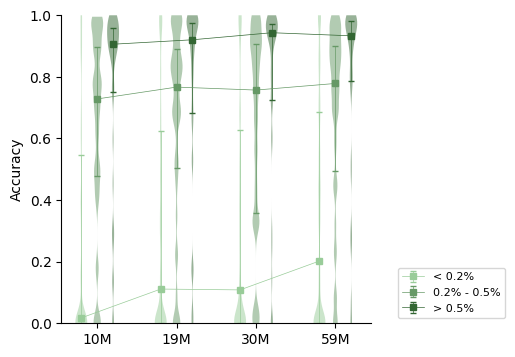

In [273]:
plot_props_list = [
    {
        'metric_to_plot': 'accuracy',
        'label': 'Accuracy',
        'ylim': (0, 1),
        'show_legend': True,
        'show_violin': True,
    },
    # {
    #     'metric_to_plot': 'auc',
    #     'label': 'AUC',
    #     'ylim': (0.75, 1),
    #     'show_legend': True
    # },
]

plot_labels = [
    f'< {100 * train_cell_fraction_thresholds[1]:.1f}%',
    f'{100 * train_cell_fraction_thresholds[1]:.1f}% - {100 * train_cell_fraction_thresholds[2]:.1f}%',
    f'> {100 * train_cell_fraction_thresholds[2]:.1f}%',
]

offsets = [-0.2, 0, 0.2]
colors = [(0.6, 0.8, 0.6), (0.4, 0.6, 0.4), (0.2, 0.4, 0.2)]

for plot_props in plot_props_list:

    fig, ax = plt.subplots(figsize=(4, 4))

    for i in range(len(train_cell_fraction_thresholds) - 1):

        sub_stats_df = stats_df[stats_df["i_threshold"] == i]

        y = sub_stats_df[f"{plot_props['metric_to_plot']}_mean"].values
        y_med = sub_stats_df[f"{plot_props['metric_to_plot']}_50"].values
        y_hi = sub_stats_df[f"{plot_props['metric_to_plot']}_75"].values
        y_lo = sub_stats_df[f"{plot_props['metric_to_plot']}_25"].values
        y_err = np.vstack([y_med - y_lo, y_hi - y_med])
        
        if plot_props['show_violin']:
            points = []
            for prefix in prefix_list:
                points.append(points_for_violin[(prefix, i)])

            violin_parts = ax.violinplot(
                points,
                np.arange(len(prefix_list)) + offsets[i],
                side='both',
                showextrema=False,
                bw_method=0.1,
                widths=0.15,
            )

            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])  # Set face color
                pc.set_edgecolor(None)    # Set edge color
                pc.set_alpha(0.5)            # Set transparency

        ax.errorbar(
            np.arange(len(prefix_list)) + offsets[i],
            y_med,
            y_err,
            fmt='s',
            label=plot_labels[i],
            color=colors[i],
            lw=0.5,
            capsize=2,
            markersize=4,
            linestyle='-'
        )


        ax.set_xticks(np.arange(len(prefix_list)))
        ax.set_xticklabels([x[:3] for x in prefix_list])
        if plot_props['show_legend']:
            # move the legend outside the plot
            ax.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.45, 0))
        ax.set_ylim(plot_props['ylim'])
        ax.set_ylabel(plot_props['label'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


In [251]:
per_cell_type_stats_dict[(prefix_list[-1], 2)].sort_values("accuracy", ascending=False)

,val_adata_id,accuracy
46,48,1.000000
45,47,1.000000
40,42,1.000000
88,97,1.000000
48,50,1.000000
...,...,...
89,98,0.300050
67,69,0.191801
101,110,0.152578
100,109,0.044177


In [211]:
df[df['labels'] == 'vip GABAergic cortical interneuron'].head(10)

,prefix,val_adata_id,metadata_predictions_type,labels,names,pred_labels,pred_names,loss,top_1_call,top_1_score,...,top_10_call,top_10_score,hop_0_call,hop_1_call,hop_2_call,hop_3_call,cell_type,train_donor_dataset_count,train_cell_count,train_cell_fraction
32578,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-25.930508,0,0.000938,...,0,1.668930e-06,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33007,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-22.916759,0,0.000174,...,0,6.556511e-07,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33267,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-11.456532,0,0.380691,...,0,1.178980e-04,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33349,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-20.421757,0,0.011641,...,0,1.728535e-06,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33350,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-19.790600,0,0.000942,...,0,-8.344650e-07,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33529,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-16.851460,0,0.006490,...,0,2.980232e-06,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33555,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,astrocyte,CL:0000127,-11.417817,0,0.501340,...,0,3.779531e-04,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33686,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-9.786108,0,0.489706,...,1,9.999686e-01,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
33868,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-13.541454,0,0.275758,...,0,1.382828e-05,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986
34372,10M_001_bs1536,23,rand_wo_XY,vip GABAergic cortical interneuron,CL:4023016,neuron,CL:0000540,-20.893860,0,0.006530,...,0,2.920628e-06,0.0,0.0,0.0,0.0,vip GABAergic cortical interneuron,232,257900,0.005986


### Sex

##### Parse data

In [5]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score


key = "sex"

metadata_predictions_root_paths = [
    metadata_predictions_rand_wo_XY_root_path,
    metadata_predictions_rand_w_XY_root_path,
    metadata_predictions_rand_w_X_root_path,
]

metadata_predictions_types = [
    'rand_wo_XY',
    'rand_w_XY',
    'rand_w_X',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            labels_n = meta_adata.obs[f"{key}"].values
            names_n = meta_adata.obs[f"{key}_ontology_term_id"].values

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]
            probs_nk = meta_adata.obsm[f"{key}_class_probs"]
            
            labels_codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)

            # record cell types
            cell_type_n = meta_adata.obs[f"cell_type"].values

            # drop nans
            valid_indices = ~np.isnan(labels_codes_n)

            if np.sum(valid_indices) == 0:
                continue

            logits_nk = logits_nk[valid_indices]
            probs_nk = probs_nk[valid_indices]
            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]
            cell_type_n = cell_type_n[valid_indices]
            labels_codes_n = labels_codes_n[valid_indices].astype(int)
            scores_n = logits_nk[:, 1]

            n_rows = len(labels_n)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows
            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["cell_type"] += cell_type_n.tolist()

            results[f"label_codes"] += labels_codes_n.tolist()
            results[f"scores"] += scores_n.tolist()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(results)

In [7]:
df

,prefix,val_adata_id,metadata_predictions_type,labels,names,cell_type,label_codes,scores
0,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.090517
1,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.160276
2,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,unknown,0,-0.226952
3,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.069796
4,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,unknown,0,-0.051056
...,...,...,...,...,...,...,...,...
2364607,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.816644
2364608,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.440763
2364609,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.397794
2364610,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.238744


In [8]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})
bq_cell_type_stats_df
bq_cell_type_stats_df["train_cell_fraction"] = \
    bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [9]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="cell_type", right_on="cell_type", how="left").dropna()

In [10]:
df

,prefix,val_adata_id,metadata_predictions_type,labels,names,cell_type,label_codes,scores,train_donor_dataset_count,train_cell_count,train_cell_fraction
0,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.090517,904.0,1394984.0,0.032378
1,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.160276,904.0,1394984.0,0.032378
3,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,oligodendrocyte,0,-0.069796,904.0,1394984.0,0.032378
5,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,cerebellar granule cell,0,-0.104820,42.0,71069.0,0.001650
6,10M_001_bs1536,1,rand_wo_XY,male,PATO:0000384,cerebellar granule cell,0,-0.154926,42.0,71069.0,0.001650
...,...,...,...,...,...,...,...,...,...,...,...
2364607,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.816644,433.0,604373.0,0.014028
2364608,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.440763,433.0,604373.0,0.014028
2364609,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.397794,433.0,604373.0,0.014028
2364610,59M_001_bs3072,110,rand_w_X,male,PATO:0000384,malignant cell,0,-0.238744,433.0,604373.0,0.014028


In [11]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__sex__03_03_2025.csv"), index=False)

##### Generate stats

In [274]:
df = pd.read_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__sex__03_03_2025.csv"))

In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

metadata_predictions_types = [
    'rand_wo_XY',
    'rand_w_XY',
    'rand_w_X'
]

stats = defaultdict(list)

min_train_cell_fraction = 0.

def compute_auc(group):
    # Optionally, skip groups with fewer than 10 samples
    if len(group) < 10:
        return np.nan
    # A valid ROC AUC requires both classes to be present in the "loss" column.
    if group[f"label_codes"].nunique() < 2:
        return np.nan
    return roc_auc_score(group[f"label_codes"], group["scores"])


points_for_violin = dict()
per_cell_type_stats_dict = dict()

for prefix in tqdm(prefix_list):
    for metadata_predictions_type in metadata_predictions_types:

        _sub_df = df[
            (df["prefix"] == prefix) &
            (df["metadata_predictions_type"] == metadata_predictions_type) &
            (df["train_cell_fraction"] >= min_train_cell_fraction)
        ]

        _sub_df = _sub_df.groupby(["cell_type"]).filter(lambda x: len(x) >= 10)
        n_cell_types = len(_sub_df["cell_type"].unique())
                
        # calculate AUC
        per_cell_type_stats = (
            _sub_df.groupby("cell_type")
            .apply(compute_auc)
            .dropna()
            .reset_index(name="auc")
        )

        points_for_violin[(prefix, metadata_predictions_type)] = per_cell_type_stats["auc"].values
        per_cell_type_stats_dict[(prefix, metadata_predictions_type)] = per_cell_type_stats
        
        quants = np.quantile(per_cell_type_stats["auc"], [0.25, 0.5, 0.75])

        stats["prefix"].append(prefix)
        stats["metadata_predictions_type"].append(metadata_predictions_type)
        stats["n_cell_types"].append(n_cell_types)
        stats["auc_25"].append(quants[0])
        stats["auc_50"].append(quants[1])
        stats["auc_75"].append(quants[2])

  0%|          | 0/4 [00:00<?, ?it/s]

In [276]:
stats_df = pd.DataFrame(stats)

In [277]:
stats_df

,prefix,metadata_predictions_type,n_cell_types,auc_25,auc_50,auc_75
0,10M_001_bs1536,rand_wo_XY,243,0.255901,0.417649,0.578366
1,10M_001_bs1536,rand_w_XY,243,0.523314,0.747785,0.927046
2,10M_001_bs1536,rand_w_X,243,0.480549,0.667245,0.884572
3,19M_001_bs2048,rand_wo_XY,243,0.202764,0.433269,0.620811
4,19M_001_bs2048,rand_w_XY,243,0.817523,0.918605,0.981203
5,19M_001_bs2048,rand_w_X,243,0.400776,0.658629,0.875414
6,30M_001_bs2560,rand_wo_XY,243,0.302126,0.461800,0.636455
7,30M_001_bs2560,rand_w_XY,243,0.869489,0.959909,0.996988
8,30M_001_bs2560,rand_w_X,243,0.555919,0.778308,0.931818
9,59M_001_bs3072,rand_wo_XY,243,0.301981,0.438782,0.617952


##### Plot

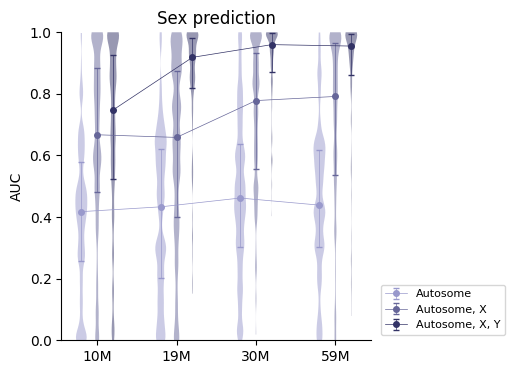

In [280]:
plot_props_list = [
    {
        'metric_to_plot': 'auc',
        'label': 'AUC',
        'ylim': (0, 1),
        'show_legend': True,
        'show_violin': True
    },
]

metadata_predictions_types = [
    'rand_wo_XY',
    'rand_w_X',
    'rand_w_XY'
]

plot_labels = [
    'Autosome',
    'Autosome, X',
    'Autosome, X, Y'
]

offsets = [-0.2, 0, 0.2]

for plot_props in plot_props_list:

    fig, ax = plt.subplots(figsize=(4, 4))

    colors = [(0.6, 0.6, 0.8), (0.4, 0.4, 0.6), (0.2, 0.2, 0.4)]

    for i, metadata_predictions_type in enumerate(metadata_predictions_types):
        
        sub_stats_df = stats_df[stats_df["metadata_predictions_type"] == metadata_predictions_type]
        
        y = sub_stats_df[f"{plot_props['metric_to_plot']}_50"].values
        y_hi = sub_stats_df[f"{plot_props['metric_to_plot']}_75"].values
        y_lo = sub_stats_df[f"{plot_props['metric_to_plot']}_25"].values
        y_err = np.vstack([y - y_lo, y_hi - y])
        
        if plot_props['show_violin']:
            points = []
            for prefix in prefix_list:
                points.append(points_for_violin[(prefix, metadata_predictions_type)])

            violin_parts = ax.violinplot(
                points,
                np.arange(len(prefix_list)) + offsets[i],
                side='both',
                showextrema=False,
                bw_method=0.1,
                widths=0.15,
            )

            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])  # Set face color
                pc.set_edgecolor(None)    # Set edge color
                pc.set_alpha(0.5)            # Set transparency

        ax.errorbar(
            np.arange(len(prefix_list)) + offsets[i],
            y,
            y_err,
            fmt='o',
            label=plot_labels[i],
            color=colors[i],
            lw=0.5,
            capsize=2,
            markersize=4,
            linestyle='-'
        )


        ax.set_xticks(np.arange(len(prefix_list)))
        ax.set_xticklabels([x[:3] for x in prefix_list])
        if plot_props['show_legend']:
            # move the legend outside the plot
            ax.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.45, 0))
        ax.set_ylim(plot_props['ylim'])
        ax.set_ylabel(plot_props['label'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Sex prediction')
    # fig.tight_layout()

In [60]:
# The sex of which cell types are most predictable and least predictable?
per_cell_type_stats_dict[(prefix_list[-1], "rand_wo_XY")].sort_values("auc", ascending=False)

,cell_type,auc
69,interneuron,0.999280
103,neural cell,0.986866
89,mesenchymal cell,0.947691
53,enterocyte,0.941811
22,alternatively activated macrophage,0.933333
...,...,...
106,neutrophil,0.000000
28,capillary endothelial cell,0.000000
17,Schwann cell,0.000000
116,pulmonary artery endothelial cell,0.000000


In [56]:
# The sex of which cell types are most predictable and least predictable?
per_cell_type_stats_dict[(prefix_list[-1], "rand_w_X")].sort_values("auc", ascending=False)

,cell_type,auc
20,adipocyte of epicardial fat of left ventricle,1.000000
16,M cell of gut,1.000000
54,enteroendocrine cell,1.000000
37,chandelier pvalb GABAergic cortical interneuron,1.000000
102,near-projecting glutamatergic cortical neuron,1.000000
...,...,...
57,epithelial cell of lung,0.043528
131,vein endothelial cell,0.002664
28,capillary endothelial cell,0.000138
106,neutrophil,0.000000


In [57]:
# The sex of which cell types are most predictable and least predictable?
per_cell_type_stats_dict[(prefix_list[-1], "rand_w_XY")].sort_values("auc", ascending=False)

,cell_type,auc
69,interneuron,1.000000
71,intestine goblet cell,1.000000
14,L5 extratelencephalic projecting glutamatergic...,1.000000
15,L6b glutamatergic cortical neuron,1.000000
16,M cell of gut,1.000000
...,...,...
131,vein endothelial cell,0.205567
121,smooth muscle cell,0.183007
27,bronchus fibroblast of lung,0.173010
28,capillary endothelial cell,0.128099


### Development stage

We will coarsen into 6 classes.

##### Parse data

In [281]:
val_meta_df = pd.read_csv(
    os.path.join(root_path, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

In [282]:
val_meta_df.columns

Index(['dataset_id', 'donor_id', 'n_unique_cell_types',
       'cell_type_unknown_fraction', 'known_cell_type_mean_dist_from_root',
       'n_cells', 'tissue_name_ont_coarsename_coarseont', 'n_tissues',
       'development_stage', 'development_stage_ontology_term_id',
       'coarse_development_stage', 'coarse_development_stage_ontology_id',
       'disease', 'disease_ontology_term_id', 'sex', 'coarse_tissue',
       'rare_triple'],
      dtype='object')

In [283]:
coarse_development_stage_labels = val_meta_df['coarse_development_stage'].dropna().unique()

In [284]:
for label in coarse_development_stage_labels:
    print(label)

60-79 year-old stage
80 year-old and over stage
fetal stage
middle aged stage
pediatric stage
young adult stage


In [285]:
# load ontology resources
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "hsapdv_benchmarking_resource.pkl"), "rb") as f:
    hsapdv_benchmarking_resource_dict = pickle.load(f)
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "hsapdv_propagation_resource.pkl"), "rb") as f:
    hsapdv_propagation_resource_dict = pickle.load(f)

In [286]:
from collections import defaultdict

# some labels might map to multiple terms, we catch all of them
coarse_label_to_term_ids_map = defaultdict(list)
for coarse_label in coarse_development_stage_labels:
    for term_id, label in hsapdv_propagation_resource_dict['ontology_term_id_to_label'].items():
        if label == coarse_label:
            coarse_label_to_term_ids_map[coarse_label].append(term_id)

# obtain all descendants of each coarse term
coarse_label_to_descendants_term_ids_map = defaultdict(set)
for coarse_label, term_ids in coarse_label_to_term_ids_map.items():
    for term_id in term_ids:
        coarse_label_to_descendants_term_ids_map[coarse_label].add(term_id)
        if term_id in hsapdv_benchmarking_resource_dict:
            coarse_label_to_descendants_term_ids_map[coarse_label].update(
                hsapdv_benchmarking_resource_dict[term_id]['all_descendants'])
            
for coarse_label, descendants_term_ids in coarse_label_to_descendants_term_ids_map.items():
    print(coarse_label, len(descendants_term_ids))

# are these mutually exclusive? they'd better be!
for label1, term_ids1 in coarse_label_to_descendants_term_ids_map.items():
    for label2, term_ids2 in coarse_label_to_descendants_term_ids_map.items():
        if label1 != label2:
            assert len(term_ids1.intersection(term_ids2)) == 0

all_coarse_labels = np.asarray(list(coarse_label_to_descendants_term_ids_map.keys()))

60-79 year-old stage 23
80 year-old and over stage 22
fetal stage 26
middle aged stage 24
pediatric stage 33
young adult stage 30


In [ ]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from scipy.special import logsumexp

key = "development_stage"

metadata_predictions_root_paths = [
    metadata_predictions_rand_wo_XY_root_path,
    metadata_predictions_rand_w_XY_root_path,
]

metadata_predictions_types = [
    'rand_wo_XY',
    'rand_w_XY',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]
            probs_nk = meta_adata.obsm[f"{key}_class_probs"]

            # get coarsening indices (we use `j` for coarse label index, in the other appears in all_coarse_labels)
            coarse_label_to_idx_map = defaultdict(list)
            idx_to_j_map = dict()

            for j, coarse_label in enumerate(all_coarse_labels):
                descendants_term_ids = coarse_label_to_descendants_term_ids_map[coarse_label]
                for descendants_term_id in descendants_term_ids:
                    if descendants_term_id in mapper:
                        coarse_label_to_idx_map[coarse_label].append(mapper[descendants_term_id])
                        idx_to_j_map[mapper[descendants_term_id]] = j

            # get coarsened logits
            logits_coarse_nj = np.zeros((logits_nk.shape[0], len(all_coarse_labels)))
            for j, coarse_label in enumerate(all_coarse_labels):
                idx = coarse_label_to_idx_map[coarse_label]
                logits_coarse_nj[:, j] = logsumexp(logits_nk[:, idx], -1)
            
            # renormalize
            logits_coarse_nj = logits_coarse_nj - logsumexp(logits_coarse_nj, -1)[:, None]

            # the coarse ground truth label
            labels_n = meta_adata.obs[f"{key}"].values
            names_n = meta_adata.obs[f"{key}_ontology_term_id"].values
            codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)
            coarse_codes_n = np.asarray([idx_to_j_map[code] if code in idx_to_j_map else np.nan for code in codes_n])

            # record cell types
            cell_type_n = meta_adata.obs[f"cell_type"].values

            # drop nans
            valid_indices = (~np.isnan(codes_n)) & (~np.isnan(coarse_codes_n))

            if np.sum(valid_indices) == 0:
                continue

            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]
            cell_type_n = cell_type_n[valid_indices]
            coarse_codes_n = coarse_codes_n[valid_indices].astype(int)

            n_rows = len(labels_n)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows

            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["cell_type"] += cell_type_n.tolist()
            results[f"coarse_codes"] += coarse_codes_n.tolist()

            for j in range(len(all_coarse_labels)):
                results[f"logits_coarse_{j}"] += logits_coarse_nj[valid_indices, j].tolist()

In [173]:
df = pd.DataFrame(results)

In [204]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})
bq_cell_type_stats_df
bq_cell_type_stats_df["train_cell_fraction"] = bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [205]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="cell_type", right_on="cell_type", how="left").dropna()

In [264]:
validation_meta_df = pd.read_csv(
    os.path.join(root_path, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

# Stephen's validatdion table
# what we have called intestine is actually "small intestine"
tissue_ontology_term_id_to_coarse_name_map = dict()
for row in validation_meta_df['tissue_name_ont_coarsename_coarseont'].values:
    split_row = row.strip("()").split(', ')
    coarse_name = split_row[2].strip("'")
    if coarse_name == "intestine":
        coarse_name = "small intestine"
    tissue_ontology_term_id_to_coarse_name_map[split_row[1].strip("'")] = coarse_name

val_adata_id_to_coarse_tissue_map = dict()
for val_idx in tqdm(range(1, 111)):
    
    val_adata_path = os.path.join(root_path, "data", "cellariumgpt_validation", f"extract_{val_idx}.h5ad")
    val_adata = sc.read_h5ad(val_adata_path)

    obs_df = val_adata.obs
    val_adata_id_to_coarse_tissue_map[val_idx] = obs_df['tissue_ontology_term_id'].map(
        tissue_ontology_term_id_to_coarse_name_map).iloc[0]

  0%|          | 0/110 [00:00<?, ?it/s]

In [265]:
df["coarse_tissue"] = df["val_adata_id"].map(val_adata_id_to_coarse_tissue_map)

In [267]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__development_stage__03_03_2025.csv"), index=False)

##### Generate stats

In [288]:
df = pd.read_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__development_stage__03_03_2025.csv"))

In [ ]:
from sklearn.preprocessing import label_binarize

metadata_predictions_types = [
    # 'rand_wo_XY',
    'rand_w_XY'
]

coarse_tissues = [
    "brain",
    "heart",
    "kidney",
    "liver",
    "blood",
    "lung",
    "small intestine",
]

stats = defaultdict(list)

min_train_cell_fraction = 0.0001

def compute_auc(group):
    
    if len(group) < 10:
        return np.nan
    
    if group[f"coarse_codes"].nunique() < 2:
        return np.nan

    one_hot_codes_nj = label_binarize(group[f"coarse_codes"].values, classes=np.arange(len(all_coarse_labels)))
    
    probs_nj = np.zeros(one_hot_codes_nj.shape)
    for j in range(len(all_coarse_labels)):
        probs_nj[:, j] = np.exp(group[f"logits_coarse_{j}"].values)
    assert np.allclose(probs_nj.sum(axis=1), 1)
    
    raw_auc = roc_auc_score(one_hot_codes_nj, probs_nj, average=None, multi_class='ovr')
    auc = np.nanmean(raw_auc)

    return auc


points_for_violin = dict()
per_cell_type_stats_dict = dict()

for prefix in tqdm(prefix_list):
    for metadata_predictions_type in metadata_predictions_types:
        for coarse_tissue in coarse_tissues:
            _sub_df = df[
                (df["prefix"] == prefix) &
                (df["metadata_predictions_type"] == metadata_predictions_type) &
                (df["train_cell_fraction"] >= min_train_cell_fraction) &
                (df["coarse_tissue"] == coarse_tissue)
            ]

            _sub_df = _sub_df.groupby(["cell_type"]).filter(lambda x: len(x) >= 10)
            n_cell_types = len(_sub_df["cell_type"].unique())


            # group = sub_df
            # one_hot_codes_nj = label_binarize(group[f"coarse_codes"], classes=np.arange(len(all_coarse_labels)))
            
            # probs_nj = np.zeros(one_hot_codes_nj.shape)
            # for j in range(len(all_coarse_labels)):
            #     probs_nj[:, j] = np.exp(group[f"logits_coarse_{j}"])
            # assert np.allclose(probs_nj.sum(axis=1), 1)

            # auc = roc_auc_score(one_hot_codes_nj, probs_nj, average='macro')

            # stats["prefix"].append(prefix)
            # stats["metadata_predictions_type"].append(metadata_predictions_type)
            # stats["n_cell_types"].append(n_cell_types)
            # stats["auc"].append(auc)


            # calculate AUC
            per_cell_type_stats = (
                _sub_df.groupby("cell_type")
                .apply(compute_auc)
                .dropna()
                .reset_index(name="auc")
            )

            points_for_violin[(prefix, metadata_predictions_type, coarse_tissue)] = per_cell_type_stats["auc"].values
            per_cell_type_stats_dict[(prefix, metadata_predictions_type, coarse_tissue)] = per_cell_type_stats
            
            if len(per_cell_type_stats) == 0:
                continue
            
            quants = np.quantile(per_cell_type_stats["auc"], [0.25, 0.5, 0.75])
            auc_mean = np.nanmean(per_cell_type_stats["auc"])

            stats["prefix"].append(prefix)
            stats["metadata_predictions_type"].append(metadata_predictions_type)
            stats["coarse_tissue"].append(coarse_tissue)

            stats["n_cell_types"].append(n_cell_types)
            stats["auc_25"].append(quants[0])
            stats["auc_50"].append(quants[1])
            stats["auc_75"].append(quants[2])
            stats["auc_mean"].append(auc_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site

In [293]:
stats_df = pd.DataFrame(stats)
stats_df

,prefix,metadata_predictions_type,coarse_tissue,n_cell_types,auc_25,auc_50,auc_75,auc_mean
0,10M_001_bs1536,rand_w_XY,brain,47,0.479248,0.619689,0.724061,0.625101
1,10M_001_bs1536,rand_w_XY,heart,20,0.539679,0.614594,0.667421,0.553523
2,10M_001_bs1536,rand_w_XY,liver,9,0.239645,0.472204,0.578763,0.462243
3,10M_001_bs1536,rand_w_XY,blood,58,0.582606,0.752851,0.817974,0.702261
4,10M_001_bs1536,rand_w_XY,lung,52,0.457357,0.577314,0.696895,0.544657
5,10M_001_bs1536,rand_w_XY,small intestine,45,0.381441,0.521717,0.527962,0.465526
6,19M_001_bs2048,rand_w_XY,brain,47,0.551584,0.609105,0.791977,0.658604
7,19M_001_bs2048,rand_w_XY,heart,20,0.493673,0.517270,0.557064,0.521445
8,19M_001_bs2048,rand_w_XY,liver,9,0.688776,0.763021,0.890450,0.789002
9,19M_001_bs2048,rand_w_XY,blood,58,0.601608,0.696441,0.802608,0.693085


##### Plot

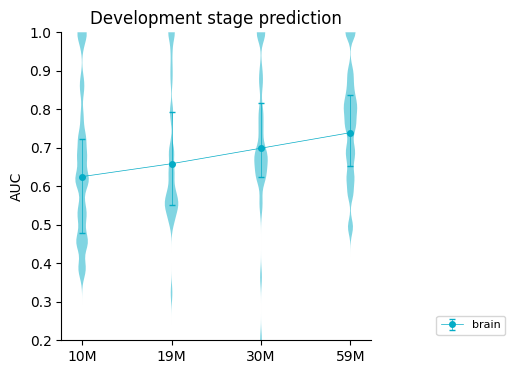

In [307]:
import colorcet as cc

metadata_predictions_type = "rand_w_XY"

plot_props_list = [
    {
        'metric_to_plot': 'auc',
        'label': 'AUC',
        'ylim': (0.2, 1),
        'show_legend': True,
        'show_violin': True,
    },
]

colors = cc.glasbey_light[3:]

plot_coarse_tissues = [
    "brain",
    # "blood",
    # "heart",
    # "lung",
    # "small intestine",
]

plot_alpha = [
    1.0,
    # 1.0,
    # 0.2,
    # 0.2,
    # 0.2,
]


plot_labels = plot_coarse_tissues
offsets = [0]

for plot_props in plot_props_list:

    fig, ax = plt.subplots(figsize=(4, 4))

    for i, coarse_tissue in enumerate(plot_coarse_tissues):
        
        sub_stats_df = stats_df[
            (stats_df["metadata_predictions_type"] == metadata_predictions_type) &
            (stats_df["coarse_tissue"] == coarse_tissue)
        ]

        if len(sub_stats_df) == 0:
            continue

        y = sub_stats_df[f"{plot_props['metric_to_plot']}_mean"].values
        y_hi = sub_stats_df[f"{plot_props['metric_to_plot']}_75"].values
        y_lo = sub_stats_df[f"{plot_props['metric_to_plot']}_25"].values
        y_err = np.vstack([y - y_lo, y_hi - y])

        if plot_props['show_violin']:
            points = []
            for prefix in prefix_list:
                points.append(points_for_violin[(prefix, metadata_predictions_type, coarse_tissue)])

            violin_parts = ax.violinplot(
                points,
                np.arange(len(prefix_list)) + offsets[i],
                side='both',
                showextrema=False,
                bw_method=0.1,
                widths=0.15,
            )

            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])  # Set face color
                pc.set_edgecolor(None)    # Set edge color
                pc.set_alpha(0.5)            # Set transparency

        ax.errorbar(
            np.arange(len(prefix_list)) + offsets[i],
            y,
            y_err,
            fmt='o',
            label=plot_labels[i],
            color=colors[i],
            lw=0.5,
            capsize=2,
            markersize=4,
            linestyle='-'
        )


        ax.set_xticks(np.arange(len(prefix_list)))
        ax.set_xticklabels([x[:3] for x in prefix_list])
        if plot_props['show_legend']:
            # move the legend outside the plot
            ax.legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.45, 0))
        ax.set_ylim(plot_props['ylim'])
        ax.set_ylabel(plot_props['label'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(f'Development stage prediction')
    # fig.tight_layout()

In [ ]:
# how many unique development stages do we have for each tissue
for coarse_tissue in coarse_tissues:
    _sub_df = df[df["coarse_tissue"] == coarse_tissue]
    n_unique_development_stages = _sub_df["coarse_codes"].nunique()
    n_cells = len(_sub_df)
    print(f"{coarse_tissue}: {n_unique_development_stages} unique development stages, {n_cells} cells")


brain: 6 unique development stages, 389520 cells
heart: 4 unique development stages, 124496 cells
kidney: 1 unique development stages, 70400 cells
liver: 2 unique development stages, 18296 cells
blood: 5 unique development stages, 399344 cells
lung: 5 unique development stages, 133128 cells
small intestine: 4 unique development stages, 89032 cells


In [303]:
# The sex of which cell types are most predictable and least predictable?
per_cell_type_stats_dict[(prefix_list[-1], "rand_w_XY", "brain")].sort_values("auc", ascending=False)

,cell_type,auc
0,Bergmann glial cell,1.000000
15,interneuron,1.000000
26,pericyte,1.000000
13,glial cell,0.999755
4,L6b glutamatergic cortical neuron,0.902277
18,mature astrocyte,0.889546
2,L2/3-6 intratelencephalic projecting glutamate...,0.867692
12,ependymal cell,0.852134
21,near-projecting glutamatergic cortical neuron,0.832105
6,astrocyte of the cerebral cortex,0.828838


### Tissue

##### Parse data

In [4]:
val_meta_df = pd.read_csv(
    os.path.join(root_path, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

In [5]:
val_meta_df.columns

Index(['dataset_id', 'donor_id', 'n_unique_cell_types',
       'cell_type_unknown_fraction', 'known_cell_type_mean_dist_from_root',
       'n_cells', 'tissue_name_ont_coarsename_coarseont', 'n_tissues',
       'development_stage', 'development_stage_ontology_term_id',
       'coarse_development_stage', 'coarse_development_stage_ontology_id',
       'disease', 'disease_ontology_term_id', 'sex', 'coarse_tissue',
       'rare_triple'],
      dtype='object')

In [6]:
# replace "intestine" with "small intestine"
val_meta_df['coarse_tissue'] = val_meta_df['coarse_tissue'].apply(lambda x: "small intestine" if x == "intestine" else x)

In [7]:
coarse_tissue_labels = val_meta_df['coarse_tissue'].dropna().unique()

In [8]:
for label in coarse_tissue_labels:
    print(label)

brain
blood
small intestine
eye
thymus
nose
heart
lung
liver
kidney


In [9]:
# censor
coarse_tissue_labels = [
    "brain",
    "heart",
    "kidney",
    "liver",
    "blood",
    "lung",
    "small intestine",
]

# # censor
# coarse_tissue_labels = [
#     "brain", #"brain",
#     "heart plus pericardium", # "heart",
#     "renal system", # "kidney",
#     "hepatobiliary system", # "liver",
#     "hematopoietic system", # "blood",
#     "respiratory system", # "lung",
#     "alimentary part of gastrointestinal system", # "small intestine",
# ]

In [10]:
# load ontology resources
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "uberon_benchmarking_resource.pkl"), "rb") as f:
    uberon_benchmarking_resource_dict = pickle.load(f)
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "uberon_propagation_resource.pkl"), "rb") as f:
    uberon_propagation_resource_dict = pickle.load(f)

In [11]:
tissue_coarsener = OntologyCoarsener(
    coarse_labels=coarse_tissue_labels,
    ontology_propagation_resource_dict=uberon_propagation_resource_dict,
    ontology_benchmarking_resource_dict=uberon_benchmarking_resource_dict,
    include_other_node=True,
    check_mutual_exclusivity=True,
    verbose=True)

Number of terms under each coarse label:
- brain: 134
- heart: 34
- kidney: 16
- liver: 5
- blood: 4
- lung: 22
- small intestine: 18
- other: 585


In [12]:
# for coarse_label in tissue_coarsener.all_coarse_labels:
#     desc_terms = tissue_coarsener.coarse_label_to_descendants_term_ids_map[coarse_label]
#     print(coarse_label)
#     for desc_term in desc_terms:
#         desc_label = uberon_propagation_resource_dict['ontology_term_id_to_label'][desc_term]
#         print(f"    {desc_label}")

In [13]:
# how many validation datasets with each coarse tissue do we have?

results = defaultdict(list)
for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
    meta_adata = load_predictions_anndata(val_adata_idx, 0, metadata_predictions_rand_wo_XY_root_path)
    val_adata_id = val_adata_idx_range[val_adata_idx]
    coarse_tissue_n = meta_adata.obs['tissue_ontology_term_id'].map(tissue_coarsener.fine_term_id_to_coarse_label_map)
    assert len(np.unique(coarse_tissue_n)) == 1
    results['val_adata_id'].append(val_adata_id)
    results['coarse_tissue'].append(coarse_tissue_n.iloc[0])

  0%|          | 0/110 [00:00<?, ?it/s]

In [14]:
val_adata_corase_tissue_df = pd.DataFrame(results)

In [15]:
for coarse_tissue in coarse_tissue_labels:
    n_datasets = np.sum(val_adata_corase_tissue_df['coarse_tissue'] == coarse_tissue)
    print(f"{coarse_tissue}: {n_datasets} validation datasets")

brain: 28 validation datasets
heart: 9 validation datasets
kidney: 5 validation datasets
liver: 6 validation datasets
blood: 34 validation datasets
lung: 15 validation datasets
small intestine: 6 validation datasets


##### Compute AUC

In [678]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from scipy.special import logsumexp

key = "tissue"

metadata_predictions_root_paths = [
    metadata_predictions_high_w_XY_root_path,
    metadata_predictions_rand_w_XY_root_path,
]

metadata_predictions_types = [
    'high_w_XY',
    'rand_w_XY',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]
            probs_nk = meta_adata.obsm[f"{key}_class_probs"]

            # get coarsening indices (we use `j` for coarse label index, in the other appears in all_coarse_labels)
            coarse_label_to_idx_map = defaultdict(list)
            idx_to_j_map = dict()

            for j, coarse_label in enumerate(tissue_coarsener.all_coarse_labels):
                descendants_term_ids = tissue_coarsener.coarse_label_to_descendants_term_ids_map[coarse_label]
                for descendants_term_id in descendants_term_ids:
                    if descendants_term_id in mapper:
                        coarse_label_to_idx_map[coarse_label].append(mapper[descendants_term_id])
                        idx_to_j_map[mapper[descendants_term_id]] = j

            # get coarsened logits
            logits_coarse_nj = np.zeros((logits_nk.shape[0], len(tissue_coarsener.all_coarse_labels)))
            for j, coarse_label in enumerate(tissue_coarsener.all_coarse_labels):
                idx = coarse_label_to_idx_map[coarse_label]
                logits_coarse_nj[:, j] = logsumexp(logits_nk[:, idx], -1)
            
            # renormalize
            logits_coarse_nj = logits_coarse_nj - logsumexp(logits_coarse_nj, -1)[:, None]

            # the coarse ground truth label
            labels_n = meta_adata.obs[f"{key}"].values
            names_n = meta_adata.obs[f"{key}_ontology_term_id"].values
            codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)
            coarse_codes_n = np.asarray([idx_to_j_map[code] if code in idx_to_j_map else np.nan for code in codes_n])

            # record cell types
            cell_type_n = meta_adata.obs[f"cell_type"].values

            # drop nans
            valid_indices = (~np.isnan(codes_n)) & (~np.isnan(coarse_codes_n))

            if np.sum(valid_indices) == 0:
                continue

            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]
            cell_type_n = cell_type_n[valid_indices]
            coarse_codes_n = coarse_codes_n[valid_indices].astype(int)

            n_rows = len(labels_n)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows

            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["cell_type"] += cell_type_n.tolist()
            results[f"coarse_codes"] += coarse_codes_n.tolist()

            for j in range(len(tissue_coarsener.all_coarse_labels)):
                results[f"logits_coarse_{j}"] += logits_coarse_nj[valid_indices, j].tolist()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [679]:
df = pd.DataFrame(results)

In [680]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})
bq_cell_type_stats_df
bq_cell_type_stats_df["train_cell_fraction"] = bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [681]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="cell_type", right_on="cell_type", how="left").dropna()

In [682]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__tissue__auc__03_03_2025.csv"), index=False)

##### Generate stats

In [683]:
df.head()

,prefix,val_adata_id,metadata_predictions_type,labels,names,cell_type,coarse_codes,logits_coarse_0,logits_coarse_1,logits_coarse_2,logits_coarse_3,logits_coarse_4,logits_coarse_5,logits_coarse_6,logits_coarse_7,train_donor_dataset_count,train_cell_count,train_cell_fraction
0,10M_001_bs1536,1,high_w_XY,dentate nucleus,UBERON:0002132,oligodendrocyte,0,-0.006080,-11.639028,-14.243156,-8.234098,-16.060185,-9.945067,-13.658438,-5.160767,904.0,1394984.0,0.032378
1,10M_001_bs1536,1,high_w_XY,dentate nucleus,UBERON:0002132,oligodendrocyte,0,-0.000114,-10.855491,-14.818631,-15.753994,-16.163912,-10.673646,-16.669695,-9.552891,904.0,1394984.0,0.032378
3,10M_001_bs1536,1,high_w_XY,dentate nucleus,UBERON:0002132,oligodendrocyte,0,-0.018111,-10.621233,-13.099631,-6.336529,-15.696574,-9.295384,-14.406444,-4.131512,904.0,1394984.0,0.032378
5,10M_001_bs1536,1,high_w_XY,dentate nucleus,UBERON:0002132,cerebellar granule cell,0,-0.007204,-8.337449,-11.130719,-10.076913,-13.889114,-11.213383,-7.973660,-5.032390,42.0,71069.0,0.001650
6,10M_001_bs1536,1,high_w_XY,dentate nucleus,UBERON:0002132,cerebellar granule cell,0,-0.001497,-9.967198,-13.935783,-14.410442,-15.539149,-13.466232,-9.104946,-6.618959,42.0,71069.0,0.001650


In [684]:
from sklearn.preprocessing import label_binarize

metadata_predictions_types = [
    'high_w_XY'
]

stats = defaultdict(list)

min_train_cell_fraction = 0.0001

def compute_auc(group):
    
    if len(group) < 10:
        return np.nan
    
    if group[f"coarse_codes"].nunique() < 2:
        return np.nan

    one_hot_codes_nj = label_binarize(group[f"coarse_codes"].values, classes=np.arange(len(tissue_coarsener.all_coarse_labels)))
    
    probs_nj = np.zeros(one_hot_codes_nj.shape)
    for j in range(len(tissue_coarsener.all_coarse_labels)):
        probs_nj[:, j] = np.exp(group[f"logits_coarse_{j}"].values)
    assert np.allclose(probs_nj.sum(axis=1), 1)
    
    raw_auc = roc_auc_score(one_hot_codes_nj, probs_nj, average=None, multi_class='ovr')
    auc = np.nanmean(raw_auc)

    return auc


def compute_accuracy(group):
    
    if len(group) < 10:
        return np.nan

    target_labels_n = group[f"coarse_codes"].values
    logits_nj = np.zeros((len(target_labels_n), len(tissue_coarsener.all_coarse_labels)))
    for j in range(len(tissue_coarsener.all_coarse_labels)):
        logits_nj[:, j] = group[f"logits_coarse_{j}"].values
    pred_labels_n = np.argmax(logits_nj, axis=1)

    accuracy = np.mean(target_labels_n == pred_labels_n)

    return accuracy



points_for_violin = dict()
per_cell_type_stats_dict = dict()

for prefix in tqdm(prefix_list):
    for metadata_predictions_type in metadata_predictions_types:
        _sub_df = df[
            (df["prefix"] == prefix) &
            (df["metadata_predictions_type"] == metadata_predictions_type) &
            (df["train_cell_fraction"] >= min_train_cell_fraction)
        ]

        _sub_df = _sub_df.groupby(["cell_type"]).filter(lambda x: len(x) >= 10)
        n_cell_types = len(_sub_df["cell_type"].unique())

        # calculate accuracy
        per_cell_type_stats = (
            _sub_df.groupby("cell_type")
            .apply(compute_accuracy)
            .dropna()
            .reset_index(name="auc")
        )

        points_for_violin[(prefix, metadata_predictions_type)] = per_cell_type_stats["auc"].values
        per_cell_type_stats_dict[(prefix, metadata_predictions_type)] = per_cell_type_stats
        
        if len(per_cell_type_stats) == 0:
            continue
        
        quants = np.quantile(per_cell_type_stats["auc"], [0.25, 0.5, 0.75])
        auc_mean = np.nanmean(per_cell_type_stats["auc"])

        stats["prefix"].append(prefix)
        stats["metadata_predictions_type"].append(metadata_predictions_type)

        stats["n_cell_types"].append(n_cell_types)
        stats["auc_25"].append(quants[0])
        stats["auc_50"].append(quants[1])
        stats["auc_75"].append(quants[2])
        stats["auc_mean"].append(auc_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

In [685]:
stats_df = pd.DataFrame(stats)
stats_df

,prefix,metadata_predictions_type,n_cell_types,auc_25,auc_50,auc_75,auc_mean
0,10M_001_bs1536,high_w_XY,212,0.039974,0.490707,0.951585,0.489814
1,19M_001_bs2048,high_w_XY,212,0.061122,0.455472,0.833333,0.461810
2,30M_001_bs2560,high_w_XY,212,0.048542,0.371165,0.706816,0.403978
3,59M_001_bs3072,high_w_XY,212,0.012216,0.163286,0.716687,0.360065


##### Plot

Text(0.5, 1.0, 'Tissue prediction')

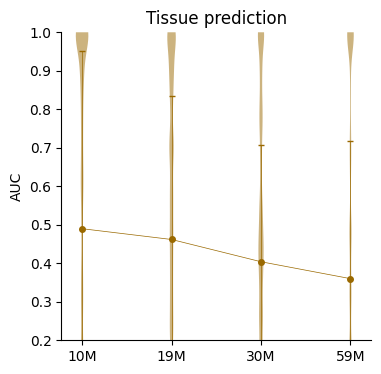

In [686]:
import colorcet as cc

metadata_predictions_type = "high_w_XY"

plot_props_list = [
    {
        'metric_to_plot': 'auc',
        'label': 'AUC',
        'ylim': (0.2, 1),
        'show_legend': True,
        'show_violin': True,
    },
]

color = cc.glasbey_light[11]

for plot_props in plot_props_list:

    fig, ax = plt.subplots(figsize=(4, 4))
        
    sub_stats_df = stats_df[
        (stats_df["metadata_predictions_type"] == metadata_predictions_type)
    ]

    if len(sub_stats_df) == 0:
        continue

    y = sub_stats_df[f"{plot_props['metric_to_plot']}_mean"].values
    y_hi = sub_stats_df[f"{plot_props['metric_to_plot']}_75"].values
    y_lo = sub_stats_df[f"{plot_props['metric_to_plot']}_25"].values
    y_err = np.vstack([y - y_lo, y_hi - y])

    if plot_props['show_violin']:
        points = []
        for prefix in prefix_list:
            points.append(points_for_violin[(prefix, metadata_predictions_type)])

        violin_parts = ax.violinplot(
            points,
            np.arange(len(prefix_list)),
            side='both',
            showextrema=False,
            bw_method=0.1,
            widths=0.15,
        )

        for pc in violin_parts['bodies']:
            pc.set_facecolor(color)  # Set face color
            pc.set_edgecolor(None)    # Set edge color
            pc.set_alpha(0.5)            # Set transparency

    ax.errorbar(
        np.arange(len(prefix_list)),
        y,
        y_err,
        fmt='o',
        lw=0.5,
        color=color,
        capsize=2,
        markersize=4,
        linestyle='-'
    )


    ax.set_xticks(np.arange(len(prefix_list)))
    ax.set_xticklabels([x[:3] for x in prefix_list])
    ax.set_ylim(plot_props['ylim'])
    ax.set_ylabel(plot_props['label'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'Tissue prediction')
# fig.tight_layout()

In [687]:
# The sex of which cell types are most predictable and least predictable?
# show all rows
with pd.option_context('display.max_rows', 50):
    display(per_cell_type_stats_dict[(prefix_list[-1], "high_w_XY")].sort_values("auc", ascending=False))

,cell_type,auc
110,granule cell,1.0
111,gut endothelial cell,1.0
21,L2/3 intratelencephalic projecting glutamaterg...,1.0
120,inhibitory interneuron,1.0
136,lamp5 GABAergic cortical interneuron,1.0
...,...,...
116,hepatocyte,0.0
204,transitional stage B cell,0.0
202,transit amplifying cell,0.0
191,renal interstitial pericyte,0.0


##### Compute accuracy

In [688]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from scipy.special import logsumexp

key = "tissue"

metadata_predictions_root_paths = [
    metadata_predictions_rand_wo_XY_root_path,
    metadata_predictions_high_w_XY_root_path,
]

metadata_predictions_types = [
    'rand_wo_XY',
    'high_w_XY',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"{key}_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            # get coarsening indices (we use `j` for coarse label index, in the other appears in all_coarse_labels)
            idx_to_j_map = dict()
            j_to_idx_map = defaultdict(list)
            for j, coarse_label in enumerate(tissue_coarsener.all_coarse_labels):
                for descendants_term_id in tissue_coarsener.coarse_label_to_descendants_term_ids_map[coarse_label]:
                    if descendants_term_id in mapper:
                        idx_to_j_map[mapper[descendants_term_id]] = j
                        j_to_idx_map[j].append(mapper[descendants_term_id])

            logits_nk = meta_adata.obsm[f"{key}_class_logits"]

            # drop "other"
            logits_nk[:, j_to_idx_map[len(tissue_coarsener.all_coarse_labels) - 1]] = -np.inf

            pred_code_n = np.argmax(logits_nk, axis=1)
            pred_coarse_code_n = np.asarray(
                [idx_to_j_map[idx] if idx in idx_to_j_map else np.nan for idx in pred_code_n])

            # the coarse ground truth label
            labels_n = meta_adata.obs[f"{key}"].values
            names_n = meta_adata.obs[f"{key}_ontology_term_id"].values
            codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)
            coarse_codes_n = np.asarray([idx_to_j_map[code] if code in idx_to_j_map else np.nan for code in codes_n])

            # did we make the right call?
            call_n = (pred_coarse_code_n == coarse_codes_n).astype(int)

            # record cell types
            cell_type_n = meta_adata.obs[f"cell_type"].values

            # drop nans
            valid_indices = (~np.isnan(codes_n)) & (~np.isnan(coarse_codes_n)) & (~np.isnan(pred_coarse_code_n)) & (~np.isnan(call_n))

            if np.sum(valid_indices) == 0:
                continue

            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]
            cell_type_n = cell_type_n[valid_indices]
            coarse_codes_n = coarse_codes_n[valid_indices].astype(int)
            pred_coarse_code_n = pred_coarse_code_n[valid_indices].astype(int)
            call_n = call_n[valid_indices]

            n_rows = len(labels_n)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows

            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["cell_type"] += cell_type_n.tolist()
            results["coarse_codes"] += coarse_codes_n.tolist()
            results["pred_coarse_codes"] += pred_coarse_code_n.tolist()
            results["call"] += call_n.tolist()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [689]:
df = pd.DataFrame(results)

In [690]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})
bq_cell_type_stats_df
bq_cell_type_stats_df["train_cell_fraction"] = bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [691]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="cell_type", right_on="cell_type", how="left").dropna()

In [692]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__tissue__accuracy__03_03_2025.csv"), index=False)

##### Sneak preview (confusion matrix)

In [693]:
df = pd.read_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__tissue__accuracy__03_03_2025.csv"))

In [694]:
from sklearn.metrics import confusion_matrix

y_true = df[(df["prefix"] == prefix_list[-1]) & (df["metadata_predictions_type"] == "rand_wo_XY")]["coarse_codes"].values
y_pred = df[(df["prefix"] == prefix_list[-1]) & (df["metadata_predictions_type"] == "rand_wo_XY")]["pred_coarse_codes"].values

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(tissue_coarsener.all_coarse_labels[:-1])), normalize='true')

Text(0, 0.5, 'True label')

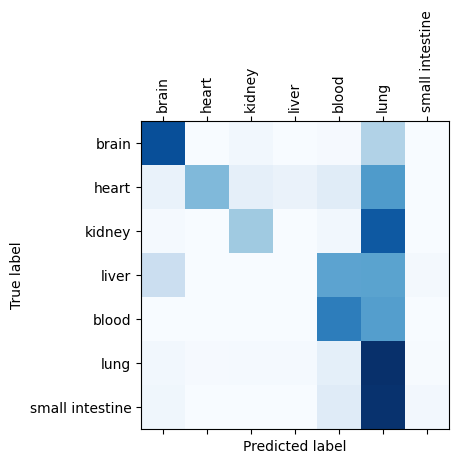

In [695]:
# plot the confision matrix using matplotlib
fig, ax = plt.subplots(figsize=(4, 4))
cax = ax.matshow(np.log1p(cm), cmap='Blues')
ax.set_xticks(np.arange(len(tissue_coarsener.all_coarse_labels[:-1])))
ax.set_yticks(np.arange(len(tissue_coarsener.all_coarse_labels[:-1])))
ax.set_xticklabels(tissue_coarsener.all_coarse_labels[:-1], rotation=90)
ax.set_yticklabels(tissue_coarsener.all_coarse_labels[:-1])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

##### Generate stats

In [696]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import label_binarize

metadata_predictions_types = [
    # 'rand_wo_XY',
    'high_w_XY'
]

stats = defaultdict(list)

min_train_cell_fraction = 0.0001

def compute_accuracy(group):
    if len(group) < 10:
        return np.nan
    accuracy = balanced_accuracy_score(group["coarse_codes"], group["pred_coarse_codes"])
    return accuracy

points_for_violin = dict()
per_cell_type_stats_dict = dict()

for prefix in tqdm(prefix_list):
    for metadata_predictions_type in metadata_predictions_types:
        _sub_df = df[
            (df["prefix"] == prefix) &
            (df["metadata_predictions_type"] == metadata_predictions_type) &
            (df["train_cell_fraction"] >= min_train_cell_fraction)
        ]

        _sub_df = _sub_df.groupby(["cell_type"]).filter(lambda x: len(x) >= 0)
        n_cell_types = len(_sub_df["cell_type"].unique())

        # calculate accuracy
        per_cell_type_stats = (
            _sub_df.groupby("cell_type")
            .apply(compute_accuracy)
            .dropna()
            .reset_index(name="accuracy")
        )

        points_for_violin[(prefix, metadata_predictions_type)] = per_cell_type_stats["accuracy"].values
        per_cell_type_stats_dict[(prefix, metadata_predictions_type)] = per_cell_type_stats
        
        if len(per_cell_type_stats) == 0:
            continue
        
        quants = np.quantile(per_cell_type_stats["accuracy"], [0.25, 0.5, 0.75])
        accuracy_mean = np.nanmean(per_cell_type_stats["accuracy"])

        stats["prefix"].append(prefix)
        stats["metadata_predictions_type"].append(metadata_predictions_type)

        stats["n_cell_types"].append(n_cell_types)
        stats["accuracy_25"].append(quants[0])
        stats["accuracy_50"].append(quants[1])
        stats["accuracy_75"].append(quants[2])
        stats["accuracy_mean"].append(accuracy_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains cl

In [697]:
stats_df = pd.DataFrame(stats)
stats_df

,prefix,metadata_predictions_type,n_cell_types,accuracy_25,accuracy_50,accuracy_75,accuracy_mean
0,10M_001_bs1536,high_w_XY,232,0.096354,0.404981,0.913234,0.467374
1,19M_001_bs2048,high_w_XY,232,0.126488,0.446124,0.925337,0.490484
2,30M_001_bs2560,high_w_XY,232,0.041151,0.325316,0.797334,0.414464
3,59M_001_bs3072,high_w_XY,232,0.008989,0.321792,0.885579,0.427038


##### Plot

Text(0.5, 1.0, 'Tissue prediction')

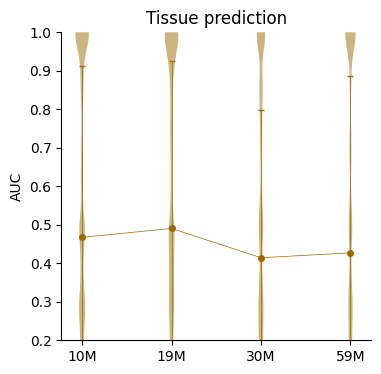

In [698]:
import colorcet as cc

metadata_predictions_type = "high_w_XY"

plot_props_list = [
    {
        'metric_to_plot': 'accuracy',
        'label': 'AUC',
        'ylim': (0.2, 1),
        'show_legend': True,
        'show_violin': True,
    },
]

color = cc.glasbey_light[11]

for plot_props in plot_props_list:

    fig, ax = plt.subplots(figsize=(4, 4))
        
    sub_stats_df = stats_df[
        (stats_df["metadata_predictions_type"] == metadata_predictions_type)
    ]

    if len(sub_stats_df) == 0:
        continue

    y = sub_stats_df[f"{plot_props['metric_to_plot']}_mean"].values
    y_hi = sub_stats_df[f"{plot_props['metric_to_plot']}_75"].values
    y_lo = sub_stats_df[f"{plot_props['metric_to_plot']}_25"].values
    y_err = np.vstack([y - y_lo, y_hi - y])

    if plot_props['show_violin']:
        points = []
        for prefix in prefix_list:
            points.append(points_for_violin[(prefix, metadata_predictions_type)])

        violin_parts = ax.violinplot(
            points,
            np.arange(len(prefix_list)),
            side='both',
            showextrema=False,
            bw_method=0.1,
            widths=0.15,
        )

        for pc in violin_parts['bodies']:
            pc.set_facecolor(color)  # Set face color
            pc.set_edgecolor(None)    # Set edge color
            pc.set_alpha(0.5)            # Set transparency

    ax.errorbar(
        np.arange(len(prefix_list)),
        y,
        y_err,
        fmt='o',
        lw=0.5,
        color=color,
        capsize=2,
        markersize=4,
        linestyle='-'
    )


    ax.set_xticks(np.arange(len(prefix_list)))
    ax.set_xticklabels([x[:3] for x in prefix_list])
    ax.set_ylim(plot_props['ylim'])
    ax.set_ylabel(plot_props['label'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f'Tissue prediction')
# fig.tight_layout()

In [701]:
# The sex of which cell types are most predictable and least predictable?
# show all rows
with pd.option_context('display.max_rows', 50):
    display(per_cell_type_stats_dict[(prefix_list[-1], "high_w_XY")].sort_values("accuracy", ascending=False))

,cell_type,accuracy
5,"CD14-positive, CD16-positive monocyte",1.0
211,vip GABAergic cortical interneuron,1.0
105,forebrain neuroblast,1.0
96,epithelial cell of lower respiratory tract,1.0
21,L2/3 intratelencephalic projecting glutamaterg...,1.0
...,...,...
193,retina horizontal cell,0.0
13,"CD8-alpha-alpha-positive, alpha-beta intraepit...",0.0
200,tracheal goblet cell,0.0
203,transit amplifying cell of colon,0.0


#### Sanity check (run on training chunk)

In [31]:
results = defaultdict(list)

meta_adata = sc.read_h5ad(
    "/home/mehrtash/data/data/metadata_predictions_rand__8192_without_XY_training_100M_old/extract_0_metadata_prediction_scores.h5ad"
)

key = "tissue"
prefix = "N/A"
metadata_predictions_type = "N/A"

terms = meta_adata.uns[f"{key}_ontology_term_ids"]
mapper = {term: idx for idx, term in enumerate(terms)}

# get coarsening indices (we use `j` for coarse label index, in the other appears in all_coarse_labels)
idx_to_j_map = dict()
j_to_idx_map = defaultdict(list)
for j, coarse_label in enumerate(tissue_coarsener.all_coarse_labels):
    for descendants_term_id in tissue_coarsener.coarse_label_to_descendants_term_ids_map[coarse_label]:
        if descendants_term_id in mapper:
            idx_to_j_map[mapper[descendants_term_id]] = j
            j_to_idx_map[j].append(mapper[descendants_term_id])

logits_nk = meta_adata.obsm[f"{key}_class_logits"]

# drop "other"
logits_nk[:, j_to_idx_map[len(tissue_coarsener.all_coarse_labels) - 1]] = -np.inf

pred_code_n = np.argmax(logits_nk, axis=1)
pred_coarse_code_n = np.asarray(
    [idx_to_j_map[idx] if idx in idx_to_j_map else np.nan for idx in pred_code_n])

# the coarse ground truth label
labels_n = meta_adata.obs[f"{key}"].values
names_n = meta_adata.obs[f"{key}_ontology_term_id"].values
codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)
coarse_codes_n = np.asarray([idx_to_j_map[code] if code in idx_to_j_map else np.nan for code in codes_n])

# did we make the right call?
call_n = (pred_coarse_code_n == coarse_codes_n).astype(int)

# record cell types
cell_type_n = meta_adata.obs[f"cell_type"].values

# drop nans
valid_indices = (~np.isnan(codes_n)) & (~np.isnan(coarse_codes_n)) & (~np.isnan(pred_coarse_code_n)) & (~np.isnan(call_n))

assert np.sum(valid_indices) > 0

labels_n = labels_n[valid_indices]
names_n = names_n[valid_indices]
cell_type_n = cell_type_n[valid_indices]
coarse_codes_n = coarse_codes_n[valid_indices].astype(int)
pred_coarse_code_n = pred_coarse_code_n[valid_indices].astype(int)
call_n = call_n[valid_indices]

n_rows = len(labels_n)

results["prefix"] += [prefix] * n_rows
results["val_adata_id"] += [val_adata_id] * n_rows
results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows

results["labels"] += labels_n.tolist()
results["names"] += names_n.tolist()
results["cell_type"] += cell_type_n.tolist()
results["coarse_codes"] += coarse_codes_n.tolist()
results["pred_coarse_codes"] += pred_coarse_code_n.tolist()
results["call"] += call_n.tolist()

Text(0, 0.5, 'True label')

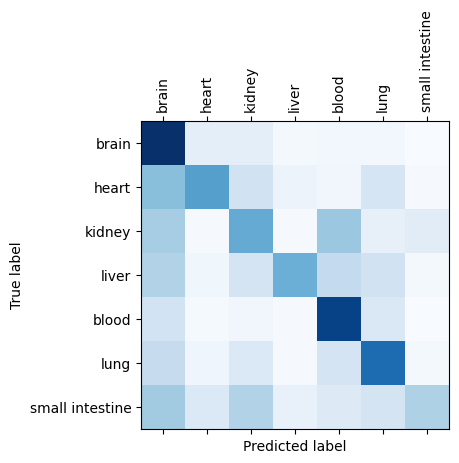

In [32]:
df = pd.DataFrame(results)

from sklearn.metrics import confusion_matrix

y_true = df["coarse_codes"].values
y_pred = df["pred_coarse_codes"].values

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(tissue_coarsener.all_coarse_labels[:-1])), normalize='true')

# plot the confision matrix using matplotlib
fig, ax = plt.subplots(figsize=(4, 4))
cax = ax.matshow(np.log1p(cm), cmap='Blues')
ax.set_xticks(np.arange(len(tissue_coarsener.all_coarse_labels[:-1])))
ax.set_yticks(np.arange(len(tissue_coarsener.all_coarse_labels[:-1])))
ax.set_xticklabels(tissue_coarsener.all_coarse_labels[:-1], rotation=90)
ax.set_yticklabels(tissue_coarsener.all_coarse_labels[:-1])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

In [33]:
results = defaultdict(list)

key = "tissue"

meta_adata = sc.read_h5ad(
    "/home/mehrtash/data/data/metadata_predictions_rand__8192_without_XY_training_100M_old/extract_0_metadata_prediction_scores.h5ad"
)

terms = meta_adata.uns[f"{key}_ontology_term_ids"]
mapper = {term: idx for idx, term in enumerate(terms)}

logits_nk = meta_adata.obsm[f"{key}_class_logits"]

pred_codes_n = np.argmax(logits_nk, axis=1)
pred_names_n = np.asarray([terms[code] for code in pred_code_n])
pred_labels_n = np.asarray([uberon_propagation_resource_dict["ontology_term_id_to_label"][term] for term in pred_names_n])

# the coarse ground truth label
labels_n = meta_adata.obs[f"{key}"].values
names_n = meta_adata.obs[f"{key}_ontology_term_id"].values
codes_n = np.asarray(meta_adata.obs[f"{key}_ontology_term_id"].map(mapper).values)

# record cell types
cell_type_n = meta_adata.obs[f"cell_type"].values

# drop nans
valid_indices = ~np.isnan(codes_n)

assert np.sum(valid_indices) > 0

codes_n = codes_n[valid_indices]
labels_n = labels_n[valid_indices]
names_n = names_n[valid_indices]

pred_codes_n = pred_codes_n[valid_indices]
pred_labels_n = pred_labels_n[valid_indices]
pred_names_n = pred_names_n[valid_indices]

cell_type_n = cell_type_n[valid_indices]

n_rows = len(labels_n)

results["labels"] += labels_n.tolist()
results["names"] += names_n.tolist()
results["codes"] += codes_n.tolist()

results["pred_labels"] += pred_labels_n.tolist()
results["pred_names"] += pred_names_n.tolist()
results["pred_codes"] += pred_codes_n.tolist()

results["cell_type"] += cell_type_n.tolist()

In [34]:
df = pd.DataFrame(results)

Text(0, 0.5, 'True label')

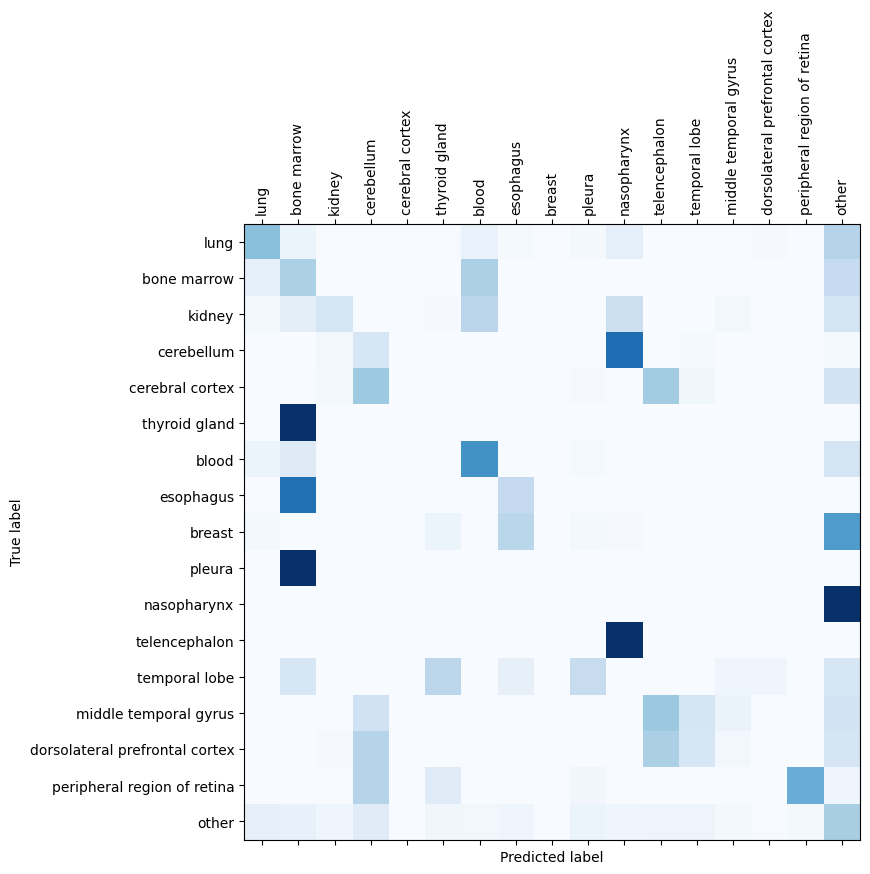

In [35]:
from sklearn.metrics import confusion_matrix

top_n_expected = 10
top_n_pred = 10
expected_codes_set = set(df["codes"].value_counts().head(top_n_expected).index)
predicted_codes_set = set(df["pred_codes"].value_counts().head(top_n_pred).index)
all_codes = sorted(expected_codes_set.union(predicted_codes_set))
other_code = np.max(all_codes) + 1

_df = df.copy()
_df["codes"] = _df["codes"].apply(lambda x: x if x in all_codes else other_code)
_df["pred_codes"] = _df["pred_codes"].apply(lambda x: x if x in all_codes else other_code)

y_true = _df["codes"].values
y_pred = _df["pred_codes"].values
labels = meta_adata.uns["tissue_labels"][all_codes]
labels = list(labels) + ["other"]

cm = confusion_matrix(y_true, y_pred, labels=all_codes + [other_code], normalize='true')

# plot the confision matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

### Disease

##### Parse data

In [733]:
val_meta_df = pd.read_csv(
    os.path.join(root_path, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

# replace "intestine" with "small intestine"
val_meta_df['coarse_tissue'] = val_meta_df['coarse_tissue'].apply(
    lambda x: "small intestine" if x == "intestine" else x)

coarse_tissue_labels = val_meta_df['coarse_tissue'].dropna().unique()

for label in coarse_tissue_labels:
    print(label)

brain
blood
small intestine
eye
thymus
nose
heart
lung
liver
kidney


In [734]:
# load ontology resources
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "uberon_benchmarking_resource.pkl"), "rb") as f:
    uberon_benchmarking_resource_dict = pickle.load(f)
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "uberon_propagation_resource.pkl"), "rb") as f:
    uberon_propagation_resource_dict = pickle.load(f)

tissue_coarsener = OntologyCoarsener(
    coarse_labels=coarse_tissue_labels,
    ontology_propagation_resource_dict=uberon_propagation_resource_dict,
    ontology_benchmarking_resource_dict=uberon_benchmarking_resource_dict,
    include_other_node=False,
    verbose=True
)
    

Number of terms under each coarse label:
- brain: 134
- blood: 4
- small intestine: 18
- eye: 35
- thymus: 1
- nose: 5
- heart: 34
- lung: 22
- liver: 5
- kidney: 16


In [735]:
# how many validation datasets with each coarse tissue do we have?

results = defaultdict(list)
for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
    meta_adata = load_predictions_anndata(val_adata_idx, 0, metadata_predictions_rand_wo_XY_root_path)
    val_adata_id = val_adata_idx_range[val_adata_idx]
    coarse_tissue_n = meta_adata.obs['tissue_ontology_term_id'].map(tissue_coarsener.fine_term_id_to_coarse_label_map)
    disease_n = meta_adata.obs['disease']
    assert len(np.unique(coarse_tissue_n)) == 1
    assert len(np.unique(disease_n)) == 1
    results['val_adata_id'].append(val_adata_id)
    results['coarse_tissue'].append(coarse_tissue_n.iloc[0])
    results['disease'].append(disease_n.iloc[0])
    
val_adata_meta_df = pd.DataFrame(results)

  0%|          | 0/110 [00:00<?, ?it/s]

In [736]:
# what diseases do we have for each coarse tissue?
for coarse_tissue in coarse_tissue_labels:
    _sub_df = val_adata_meta_df[val_adata_meta_df["coarse_tissue"] == coarse_tissue]
    print(coarse_tissue)
    print(_sub_df['disease'].value_counts())
    print()

brain
disease
normal                           10
Alzheimer disease                 3
COVID-19                          3
amyotrophic lateral sclerosis     3
dementia                          3
frontotemporal dementia           3
glioblastoma                      3
Name: count, dtype: int64

blood
disease
normal                                 19
systemic lupus erythematosus            3
common variable immunodeficiency        3
B-cell acute lymphoblastic leukemia     3
COVID-19                                3
post-COVID-19 disorder                  3
Name: count, dtype: int64

small intestine
disease
Crohn disease    3
normal           3
Name: count, dtype: int64

eye
disease
normal    1
Name: count, dtype: int64

thymus
disease
normal    2
Name: count, dtype: int64

nose
disease
normal    2
Name: count, dtype: int64

heart
disease
normal                    3
dilated cardiomyopathy    3
myocardial infarction     3
Name: count, dtype: int64

lung
disease
non-small cell lung carcinoma 

In [737]:
coarse_disease_labels = val_adata_meta_df['disease'].dropna().unique()

In [738]:
for label in coarse_disease_labels:
    print(label)

normal
systemic lupus erythematosus
Crohn disease
Alzheimer disease
COVID-19
amyotrophic lateral sclerosis
common variable immunodeficiency
non-small cell lung carcinoma
squamous cell lung carcinoma
dementia
dilated cardiomyopathy
B-cell acute lymphoblastic leukemia
lung adenocarcinoma
myocardial infarction
post-COVID-19 disorder
primary sclerosing cholangitis
frontotemporal dementia
clear cell renal carcinoma
glioblastoma


In [850]:
# coarse_disease_labels = [
#     "normal",
#     "systemic lupus erythematosus",
#     "Crohn disease",
#     # "Alzheimer disease",
#     "COVID-19",
#     "amyotrophic lateral sclerosis",
#     "common variable immunodeficiency",
#     "non-small cell lung carcinoma",
#     "squamous cell lung carcinoma",
#     "dementia",
#     "dilated cardiomyopathy",
#     "B-cell acute lymphoblastic leukemia",
#     # "lung adenocarcinoma",
#     "myocardial infarction",
#     "post-COVID-19 disorder",
#     "primary sclerosing cholangitis",
#     # "frontotemporal dementia",
#     "clear cell renal carcinoma",
#     "glioblastoma",
# ]

coarse_disease_labels = [
    "normal",
    "systemic lupus erythematosus",
    "Crohn disease",
    # "Alzheimer disease",
    "COVID-19",
    "amyotrophic lateral sclerosis",
    "common variable immunodeficiency",
    "non-small cell lung carcinoma",
    "squamous cell lung carcinoma",
    "dementia",
    "dilated cardiomyopathy",
    "B-cell acute lymphoblastic leukemia",
    # "lung adenocarcinoma",
    "myocardial infarction",
    "post-COVID-19 disorder",
    "primary sclerosing cholangitis",
    # "frontotemporal dementia",
    "clear cell renal carcinoma",
    "glioblastoma",
    # "cancer"
]

In [851]:
# coarsen disease
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "mondo_benchmarking_resource.pkl"), "rb") as f:
    mondo_benchmarking_resource_dict = pickle.load(f)
with open(os.path.join(root_path, "data", "cellariumgpt_artifacts", "ontology", "mondo_propagation_resource.pkl"), "rb") as f:
    mondo_propagation_resource_dict = pickle.load(f)

disease_coarsener = OntologyCoarsener(
    coarse_labels=coarse_disease_labels,
    ontology_propagation_resource_dict=mondo_propagation_resource_dict,
    ontology_benchmarking_resource_dict=mondo_benchmarking_resource_dict,
    include_other_node=True,
    verbose=True
)

Number of terms under each coarse label:
- normal: 1
- systemic lupus erythematosus: 1
- Crohn disease: 3
- COVID-19: 1
- amyotrophic lateral sclerosis: 3
- common variable immunodeficiency: 1
- non-small cell lung carcinoma: 3
- squamous cell lung carcinoma: 1
- dementia: 5
- dilated cardiomyopathy: 1
- B-cell acute lymphoblastic leukemia: 1
- myocardial infarction: 2
- post-COVID-19 disorder: 2
- primary sclerosing cholangitis: 1
- clear cell renal carcinoma: 1
- glioblastoma: 1
- other: 259


#### Compute balanced accuracy

In [853]:
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from scipy.special import logsumexp

metadata_predictions_root_paths = [
    metadata_predictions_high_w_XY_root_path,
    # metadata_predictions_rand_w_XY_root_path,
]

metadata_predictions_types = [
    'high_w_XY',
    # 'rand_w_XY',
]

results = defaultdict(list)


for prefix_idx in tqdm(range(len(prefix_list))):
    prefix = prefix_list[prefix_idx]
    
    for val_adata_idx in tqdm(range(len(val_adata_idx_range))):
        val_adata_id = val_adata_idx_range[val_adata_idx]

        for metadata_predictions_root_path, metadata_predictions_type in zip(
            metadata_predictions_root_paths, metadata_predictions_types):

            meta_adata = load_predictions_anndata(val_adata_idx, prefix_idx, metadata_predictions_root_path)
            
            terms = meta_adata.uns[f"disease_ontology_term_ids"]
            mapper = {term: idx for idx, term in enumerate(terms)}

            logits_nk = meta_adata.obsm[f"disease_class_logits"]
            probs_nk = meta_adata.obsm[f"disease_class_probs"]

            # get coarsening indices (we use `j` for coarse label index, in the other appears in all_coarse_labels)
            coarse_label_to_descendant_indices_map = defaultdict(list)
            idx_to_j_map = dict()

            for j, coarse_label in enumerate(disease_coarsener.all_coarse_labels):
                descendants_term_ids = disease_coarsener.coarse_label_to_descendants_term_ids_map[coarse_label]
                for descendants_term_id in descendants_term_ids:
                    if descendants_term_id in mapper:
                        coarse_label_to_descendant_indices_map[coarse_label].append(mapper[descendants_term_id])
                        idx_to_j_map[mapper[descendants_term_id]] = j

            # get coarsened logits
            logits_coarse_nj = np.zeros((logits_nk.shape[0], len(disease_coarsener.all_coarse_labels)))
            for j, coarse_label in enumerate(disease_coarsener.all_coarse_labels):
                idx = coarse_label_to_descendant_indices_map[coarse_label]
                logits_coarse_nj[:, j] = logsumexp(logits_nk[:, idx], -1)

            # renormalize
            logits_coarse_nj = logits_coarse_nj - logsumexp(logits_coarse_nj, -1)[:, None]
            
            # the coarse ground truth label
            labels_n = meta_adata.obs[f"disease"].values
            names_n = meta_adata.obs[f"disease_ontology_term_id"].values
            codes_n = np.asarray(meta_adata.obs[f"disease_ontology_term_id"].map(mapper).values)
            coarse_labels_n = np.asarray(meta_adata.obs[f"disease_ontology_term_id"].map(
                disease_coarsener.fine_term_id_to_coarse_label_map).values)
            coarse_codes_n = np.asarray([idx_to_j_map[code] if code in idx_to_j_map else np.nan for code in codes_n])

            # record cell types
            cell_type_n = meta_adata.obs[f"cell_type"].values

            # record coarse tissue type
            coarse_tissue_label_n = np.asarray(list(map(
                tissue_coarsener.fine_term_id_to_coarse_label_map.get,
                meta_adata.obs['tissue_ontology_term_id'].values)))

            # drop nans
            valid_indices = (
                (~np.isnan(codes_n)) &
                (~np.isnan(coarse_codes_n))
            )

            if np.sum(valid_indices) == 0:
                continue

            labels_n = labels_n[valid_indices]
            names_n = names_n[valid_indices]
            cell_type_n = cell_type_n[valid_indices]
            coarse_codes_n = coarse_codes_n[valid_indices].astype(int)
            coarse_labels_n = coarse_labels_n[valid_indices]
            coarse_tissue_label_n = coarse_tissue_label_n[valid_indices]
            total_mrna_umis_n = meta_adata.obs['total_mrna_umis'].values[valid_indices]
            assay_n = meta_adata.obs['assay'].values[valid_indices]
            suspension_type_n = meta_adata.obs['suspension_type'].values[valid_indices]

            n_rows = len(valid_indices)

            results["prefix"] += [prefix] * n_rows
            results["val_adata_id"] += [val_adata_id] * n_rows
            results["metadata_predictions_type"] += [metadata_predictions_type] * n_rows

            results["labels"] += labels_n.tolist()
            results["names"] += names_n.tolist()
            results["cell_type"] += cell_type_n.tolist()
            results["coarse_codes"] += coarse_codes_n.tolist()
            results["coarse_labels"] += coarse_labels_n.tolist()
            results["coarse_tissue_label"] += coarse_tissue_label_n.tolist()
            results["total_mrna_umis"] += total_mrna_umis_n.tolist()
            results["assay"] += assay_n.tolist()
            results["suspension_type"] += suspension_type_n.tolist()

            for j in range(len(disease_coarsener.all_coarse_labels)):
                results[f"logits_coarse_{j}"] += logits_coarse_nj[valid_indices, j].tolist()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [854]:
df = pd.DataFrame(results)

In [855]:
bq_cell_type_stats_csv_path = os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "bquxjob_cc87f8c_1955cb8b936.csv")
bq_cell_type_stats_df = pd.read_csv(bq_cell_type_stats_csv_path)

# delete the row "cell_type" == "unknown"
bq_cell_type_stats_df = bq_cell_type_stats_df[bq_cell_type_stats_df["cell_type"] != "unknown"]

# rename columns
bq_cell_type_stats_df = bq_cell_type_stats_df.rename(columns={
    "cell_type": "cell_type",
    "donor_dataset_count": "train_donor_dataset_count",
    "cell_count": "train_cell_count",
})
bq_cell_type_stats_df
bq_cell_type_stats_df["train_cell_fraction"] = bq_cell_type_stats_df["train_cell_count"] / bq_cell_type_stats_df["train_cell_count"].sum()

In [856]:
df = pd.merge(df, bq_cell_type_stats_df, left_on="cell_type", right_on="cell_type", how="left")

In [857]:
df.to_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__disease__accuracy__03_03_2025.csv"), index=False)

#### Generate stats

In [ ]:
df = pd.read_csv(os.path.join(
    root_path, "data", "cellariumgpt_artifacts", "metadata_predictions_scores__disease__accuracy__03_03_2025.csv"))

In [862]:
all_val_adata_ids = df["val_adata_id"].unique()

stats = defaultdict(list)

for i in tqdm(range(len(all_val_adata_ids))):
    for j in range(i + 1, len(all_val_adata_ids)):

        id_i = all_val_adata_ids[i]
        id_j = all_val_adata_ids[j]
        sub_df_i = df[df["val_adata_id"] == id_i]
        sub_df_j = df[df["val_adata_id"] == id_j]
        assay_i = sub_df_i["assay"].values[0]
        assay_j = sub_df_j["assay"].values[0]
        suspension_type_i = sub_df_i["suspension_type"].values[0]
        suspension_type_j = sub_df_j["suspension_type"].values[0]
        disease_i = sub_df_i["coarse_labels"].values[0]
        disease_j = sub_df_j["coarse_labels"].values[0]
        tissue_i = sub_df_i["coarse_tissue_label"].values[0]
        tissue_j = sub_df_j["coarse_tissue_label"].values[0]
        
        if assay_i != assay_j:
            continue
        if suspension_type_i != suspension_type_j:
            continue
        if tissue_i != tissue_j:
            continue
        if (disease_i != "normal") and (disease_j != "normal"):
            continue
        if (disease_i == "normal") and (disease_j == "normal"):
            continue
        
        if disease_i == "normal":
            normal_id = id_i
            disease_id = id_j
            normal_df = sub_df_i
            disease_df = sub_df_j
            normal_label = "normal"
            disease_label = disease_j
        else:
            normal_id = id_j
            disease_id = id_i
            normal_df = sub_df_j
            disease_df = sub_df_i
            normal_label = "normal"
            disease_label = disease_i

        for prefix in prefix_list:
            _normal_df = normal_df[normal_df["prefix"] == prefix]
            _disease_df = disease_df[disease_df["prefix"] == prefix]
            # calculate auc
            normal_index = 0
            disease_index = disease_coarsener.all_coarse_labels.tolist().index(disease_label)
            normal_df_logits_n2 = np.vstack(
                [_normal_df[f"logits_coarse_{normal_index}"].values,
                 _normal_df[f"logits_coarse_{disease_index}"].values]).T
            normal_df_logits_n2 = normal_df_logits_n2 - logsumexp(normal_df_logits_n2, -1)[:, None]
            disease_df_logits_n2 = np.vstack(
                [_disease_df[f"logits_coarse_{normal_index}"].values,
                 _disease_df[f"logits_coarse_{disease_index}"].values]).T
            disease_df_logits_n2 = disease_df_logits_n2 - logsumexp(disease_df_logits_n2, -1)[:, None]
            stacked_logits_n2 = np.vstack([normal_df_logits_n2, disease_df_logits_n2])
            stacked_disease_labels_n = np.hstack([np.zeros(len(_normal_df)), np.ones(len(_disease_df))])
            auc = roc_auc_score(stacked_disease_labels_n, stacked_logits_n2[:, 1])

            # calculate accuracy
            pred_label_n = np.argmax(stacked_logits_n2, axis=1)
            expected_label_n = stacked_disease_labels_n
            balanced_accuracy = balanced_accuracy_score(expected_label_n, pred_label_n)

            stats["prefix"].append(prefix)
            stats["normal_val_adata_id"].append(normal_id)
            stats["disease_val_adata_id"].append(disease_id)
            stats["coarse_tissue"].append(tissue_i)
            stats["disease_label"].append(disease_label)
            stats["assay"].append(assay_i)
            stats["suspension_type"].append(suspension_type_i)
            stats["auc"].append(auc)
            stats["balanced_accuracy"].append(balanced_accuracy)

  0%|          | 0/110 [00:00<?, ?it/s]

In [863]:
stats_df = pd.DataFrame(stats)

In [897]:
prefix_idx = 3
good_index = stats_df[stats_df["prefix"] == prefix_list[prefix_idx]]["auc"] > 0.5
good_coarse_tissues = stats_df[stats_df["prefix"] == prefix_list[prefix_idx]]["coarse_tissue"][good_index].values
good_disease_labels = stats_df[stats_df["prefix"] == prefix_list[prefix_idx]]["disease_label"][good_index].values
good_tissue_disease_pair_set = set(zip(good_coarse_tissues, good_disease_labels))

# filter
filtered_stats_df = stats_df[
    stats_df.apply(lambda x: (x["coarse_tissue"], x["disease_label"]) in good_tissue_disease_pair_set, axis=1)]

In [905]:
filtered_stats_df.groupby(["prefix", "coarse_tissue", "disease_label"]).agg(
    auc_mean=("auc", "mean"),
    balanced_accuracy_mean=("balanced_accuracy", "mean"),
    count=("auc", "count"),
    assay=("assay", "first"),
)

auc_mean  \
prefix         coarse_tissue   disease_label                                
10M_001_bs1536 blood           COVID-19                          0.529299   
                               common variable immunodeficiency  0.750724   
                               post-COVID-19 disorder            0.605068   
                               systemic lupus erythematosus      0.682581   
               brain           COVID-19                          0.734318   
                               amyotrophic lateral sclerosis     0.433463   
                               dementia                          0.599291   
               lung            COVID-19                          0.857496   
                               non-small cell lung carcinoma     0.160025   
                               squamous cell lung carcinoma      0.396904   
               small intestine Crohn disease                     0.707470   
19M_001_bs2048 blood           COVID-19                          0.553816   
                               common variable immunodeficiency  0.928521   
                               post-COVID-19 disorder            0.726175   
                               systemic lupus erythematosus      0.367019   
               brain           COVID-19                          0.644483   
                               amyotrophic lateral sclerosis     0.408419   
                               dementia                          0.511539   
               lung            COVID-19                          0.833453   
                               non-small cell lung carcinoma     0.297680   
                               squamous cell lung carcinoma      0.532986   
               small intestine Crohn disease                     0.431057   
30M_001_bs2560 blood           COVID-19                          0.471444   
                               common variable immunodeficiency  0.880490   
                               post-COVID-19 disorder            0.901318   
                               systemic lupus erythematosus      0.792833   
               brain           COVID-19                          0.786772   
                               amyotrophic lateral sclerosis     0.614216   
                               dementia                          0.607612   
               lung            COVID-19                          0.732230   
                               non-small cell lung carcinoma     0.924707   
                               squamous cell lung carcinoma      0.803926   
               small intestine Crohn disease                     0.548762   
59M_001_bs3072 blood           COVID-19                          0.667377   
                               common variable immunodeficiency  0.859101   
                               post-COVID-19 disorder            0.881168   
                               systemic lupus erythematosus      0.492928   
               brain           COVID-19                          0.661897   
                               amyotrophic lateral sclerosis     0.590576   
                               dementia                          0.649248   
               lung            COVID-19                          0.749953   
                               non-small cell lung carcinoma     0.724588   
                               squamous cell lung carcinoma      0.601388   
               small intestine Crohn disease                     0.644288   

                                                                 balanced_accuracy_mean  \
prefix         coarse_tissue   disease_label                                              
10M_001_bs1536 blood           COVID-19                                        0.505450   
                               common variable immunodeficiency                0.500000   
                               post-COVID-19 disorder                          0.500000   
                               systemic lupus erythematosus        

In [907]:
study_pairs = [
    ("blood", "COVID-19"),
    ("blood", "common variable immunodeficiency"),
    ("blood", "post-COVID-19 disorder"),
    ("brain", "COVID-19"),
    ("brain", "amyotrophic lateral sclerosis"),
    ("lung", "COVID-19"),
    ("small intestine", "Crohn disease")
]

val_adata_meta_df[val_adata_meta_df.apply(
    lambda x: (x["coarse_tissue"], x["disease"]) in study_pairs, axis=1)]

,val_adata_id,coarse_tissue,disease
3,4,small intestine,Crohn disease
6,7,small intestine,Crohn disease
21,22,brain,COVID-19
22,23,brain,COVID-19
23,24,brain,COVID-19
28,29,brain,amyotrophic lateral sclerosis
29,30,blood,common variable immunodeficiency
30,31,blood,common variable immunodeficiency
31,32,blood,common variable immunodeficiency
58,59,brain,amyotrophic lateral sclerosis


### Playground

In [174]:
val_adata_id = 67
meta_adata = load_predictions_anndata(val_adata_id - 1, 3, metadata_predictions_high_w_XY_root_path)
adata = sc.read_h5ad(f"/home/mehrtash/data/data/cellariumgpt_validation/extract_{val_adata_id}__processed.h5ad")
adata = adata[meta_adata.obs.index].copy()

In [175]:
adata

AnnData object with n_obs × n_vars = 1550 × 5000
    obs: 'original_cell_id', 'cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'assay', 'development_stage', 'disease', 'organism', 'self_reported_ethnicity', 'sex', 'tissue', 'total_mrna_umis', 'cell_type_distance_from_root', 'bq_row_index', 'donor_dataset_concat', 'farm_finger', 'dataset_id', 'dataset_version_id', 'cas_ingest_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'measured_genes_mask'
    obsp: 'connectivities', 'distances'

In [176]:
meta_adata

AnnData object with n_obs × n_vars = 1550 × 0
    obs: 'original_cell_id', 'cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'assay', 'development_stage', 'disease', 'organism', 'self_reported_ethnicity', 'sex', 'tissue', 'total_mrna_umis', 'cell_type_distance_from_root', 'bq_row_index', 'donor_dataset_concat', 'farm_finger', 'dataset_id', 'dataset_version_id', 'cas_ingest_id', 'cell_type_detail', 'cell_type_hop_0_call', 'cell_type_hop_1_call', 'cell_type_hop_2_call', 'cell_type_hop_3_call', 'development_stage_detail', 'development_stage_hop_0_call', 'development_stage_hop_1_call', 'development_stage_hop_2_call', 'development_stage_hop_3_call', 'disease_detail', 'disease_hop_0_call', 'disease_hop_1_call', 'disease_hop_2_call', 'dis

In [177]:
for key in meta_adata.obsm.keys():
    adata.obsm[key] = meta_adata.obsm[key]

for key in meta_adata.uns.keys():
    adata.uns[key] = meta_adata.uns[key]

In [178]:
# make hard metadata calls
keys = ["cell_type", "disease", "tissue", "development_stage", "sex"]
for key in keys:
    logits_nk = adata.obsm[f"{key}_class_logits"]
    pred_code_n = np.argmax(logits_nk, axis=1)
    mapper = {term: idx for idx, term in enumerate(meta_adata.uns[f"{key}_labels"])}
    pred_label_n = np.asarray([meta_adata.uns[f"{key}_labels"][code] for code in pred_code_n])
    adata.obs[f"{key}_hard_pred"] = pd.Categorical(pred_label_n)

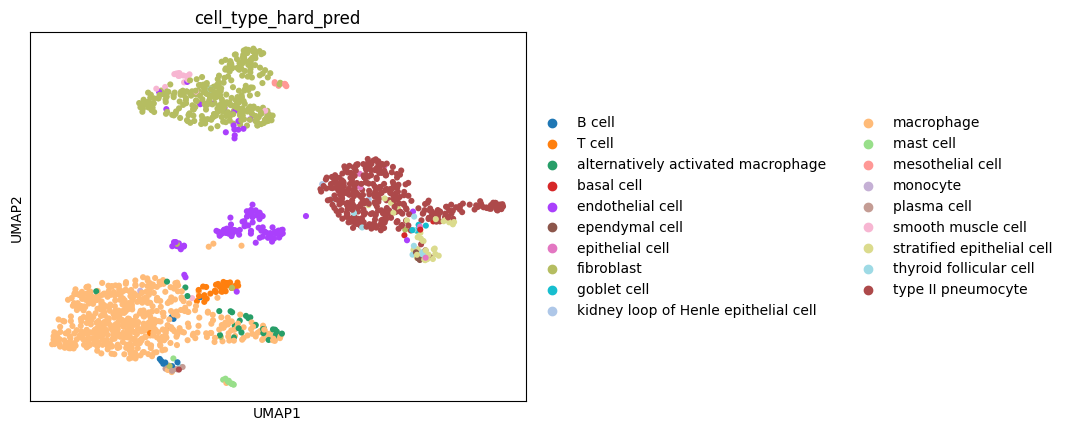

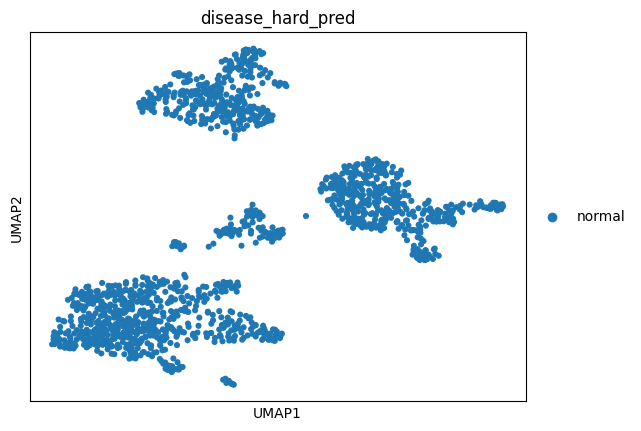

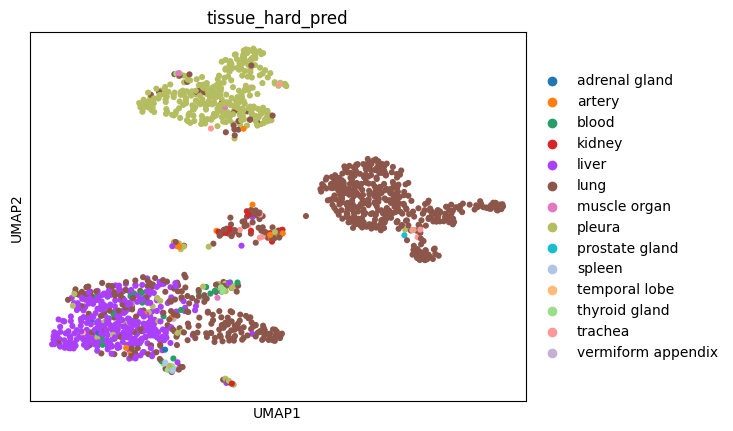

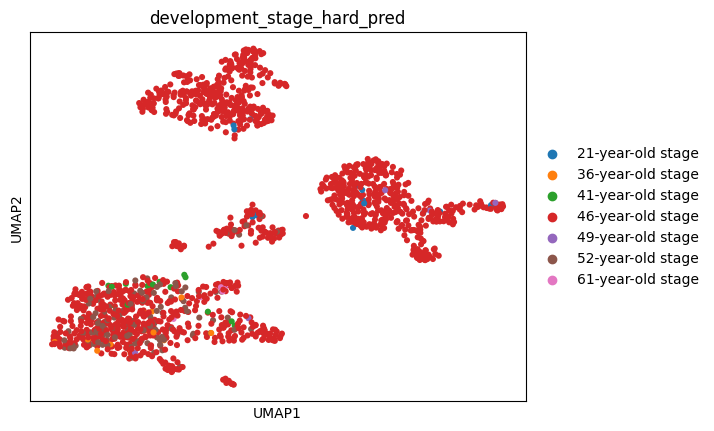

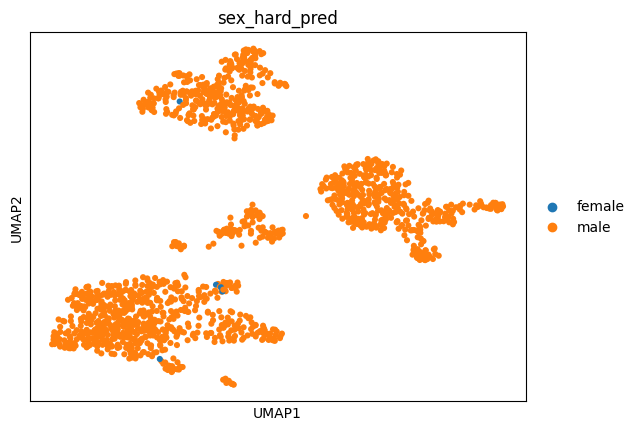

In [180]:
for key in ["cell_type_hard_pred", "disease_hard_pred", "tissue_hard_pred", "development_stage_hard_pred", "sex_hard_pred"]:
    sc.pl.umap(adata, color=key)

In [186]:
for term_id in tissue_coarsener.coarse_label_to_descendants_term_ids_map['lung']:
    print(uberon_propagation_resource_dict['ontology_term_id_to_label'][term_id])

lung parenchyma
middle lobe of lung
pulmonary lobule
alveolar system
upper lobe of left lung
lung
bronchopulmonary segment
lobe of lung
right lung lobe
lower lobe of right lung
upper lobe of right lung
left lung lobe
lower lobe of left lung
middle lobe of right lung
alveolus of lung
lingula of left lung
right lung
lower lobe of lung
pulmonary acinus
upper lobe of lung
left lung
secondary pulmonary lobule
